In [77]:
import psycopg2
from psycopg2.extensions import connection
from mes_proto_python.proto import offers_pb2
from google.protobuf.json_format import Parse
from typing import List

def read_proto_from_db(connection: connection) -> List[offers_pb2.Offer]:
    result = []
    try:
        with connection.cursor() as cursor:
            query = """SELECT details::TEXT FROM store.offers;"""
            cursor.execute(query)
            rows = cursor.fetchall()
            for row in rows:
                new_offer = offers_pb2.Offer()
                Parse(row[0], new_offer)
                result.append(new_offer)
    except psycopg2.Error as e:
        print(f"Error: {e}")
    finally:
        connection.close()
    return result


In [80]:
from typing import Dict, Any
import pandas as pd

def decimal_number_to_float(price: offers_pb2.Money):
    if price.value < 1000:
        price.value
    return price.value * 10 ** -price.scale


def offer_to_flat_dict(offer: offers_pb2.Offer) -> Dict[str, Any]:
    raw_price = decimal_number_to_float(offer.apartment.price.value)
    raw_size = decimal_number_to_float(offer.apartment.size)
    return {
        'title': offer.title,
        'description': offer.description,
        'time_scraped': offer.time_scraped.ToDatetime(),
        'price': raw_price if offer.apartment.price.value.value >= 1000 else raw_price / 100,
        'size': raw_size if raw_size > 5 else raw_size * 100,
        'address': offer.apartment.address,
        'latitude': offer.apartment.location.latitude,
        'longitude': offer.apartment.location.longitude,
        'year_built': offer.apartment.year_built if offer.apartment.year_built != 0 else None,
        'room_count': offer.apartment.room_count,
        'floor': offer.apartment.floor,
    }


def proto_list_to_dict_list(list: List[offers_pb2.Offer]):
    result = []
    for offer in list:
        try:
            result.append(offer_to_flat_dict(offer))
        except Exception as e:
            print(f"Error processing offer: {e}")
            continue  # This will move to the next item in the loop
    return result


def proto_list_to_dataframe(list: List[offers_pb2.Offer]): 
    return pd.DataFrame(proto_list_to_dict_list(list))

In [82]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

In [83]:
import psycopg2
from mes_proto_python.proto import offers_pb2
from google.protobuf.json_format import Parse

connection = psycopg2.connect(
    dbname='admin',
    user='admin',
    password='mysecretpassword',
    host='localhost',
    port='6020'
)

In [84]:
offers_proto = read_proto_from_db(connection)

In [85]:
offers_dataframe = proto_list_to_dataframe(offers_proto)

In [87]:
import numpy as np

def clear_dataframe(offers_dataframe):
    warsaw_only = offers_dataframe[((offers_dataframe['latitude'].between(52, 53.2)) & (offers_dataframe['longitude'].between(20, 22)))]
    only_numeric_values = warsaw_only.drop(['time_scraped', 'title', 'description', 'address'], axis=1)
    only_numeric_values.loc[only_numeric_values['room_count'] > 50, 'room_count'] = np.nan
    only_numeric_values.loc[only_numeric_values['room_count'] == 0, 'room_count'] = np.nan
    only_numeric_values.loc[only_numeric_values['year_built'] < 1800, 'year_built'] = np.nan
    for col in only_numeric_values.columns:
        only_numeric_values[col + '_is_nan'] = only_numeric_values[col].isna().astype(int)
    return only_numeric_values

def clear_dataframe2(offers_dataframe):
    clear = clear_dataframe(offers_dataframe)
    return clear[clear['price'] <= 10_000_000]

/Users/emilsroka/Desktop/git/masters/python-playground/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


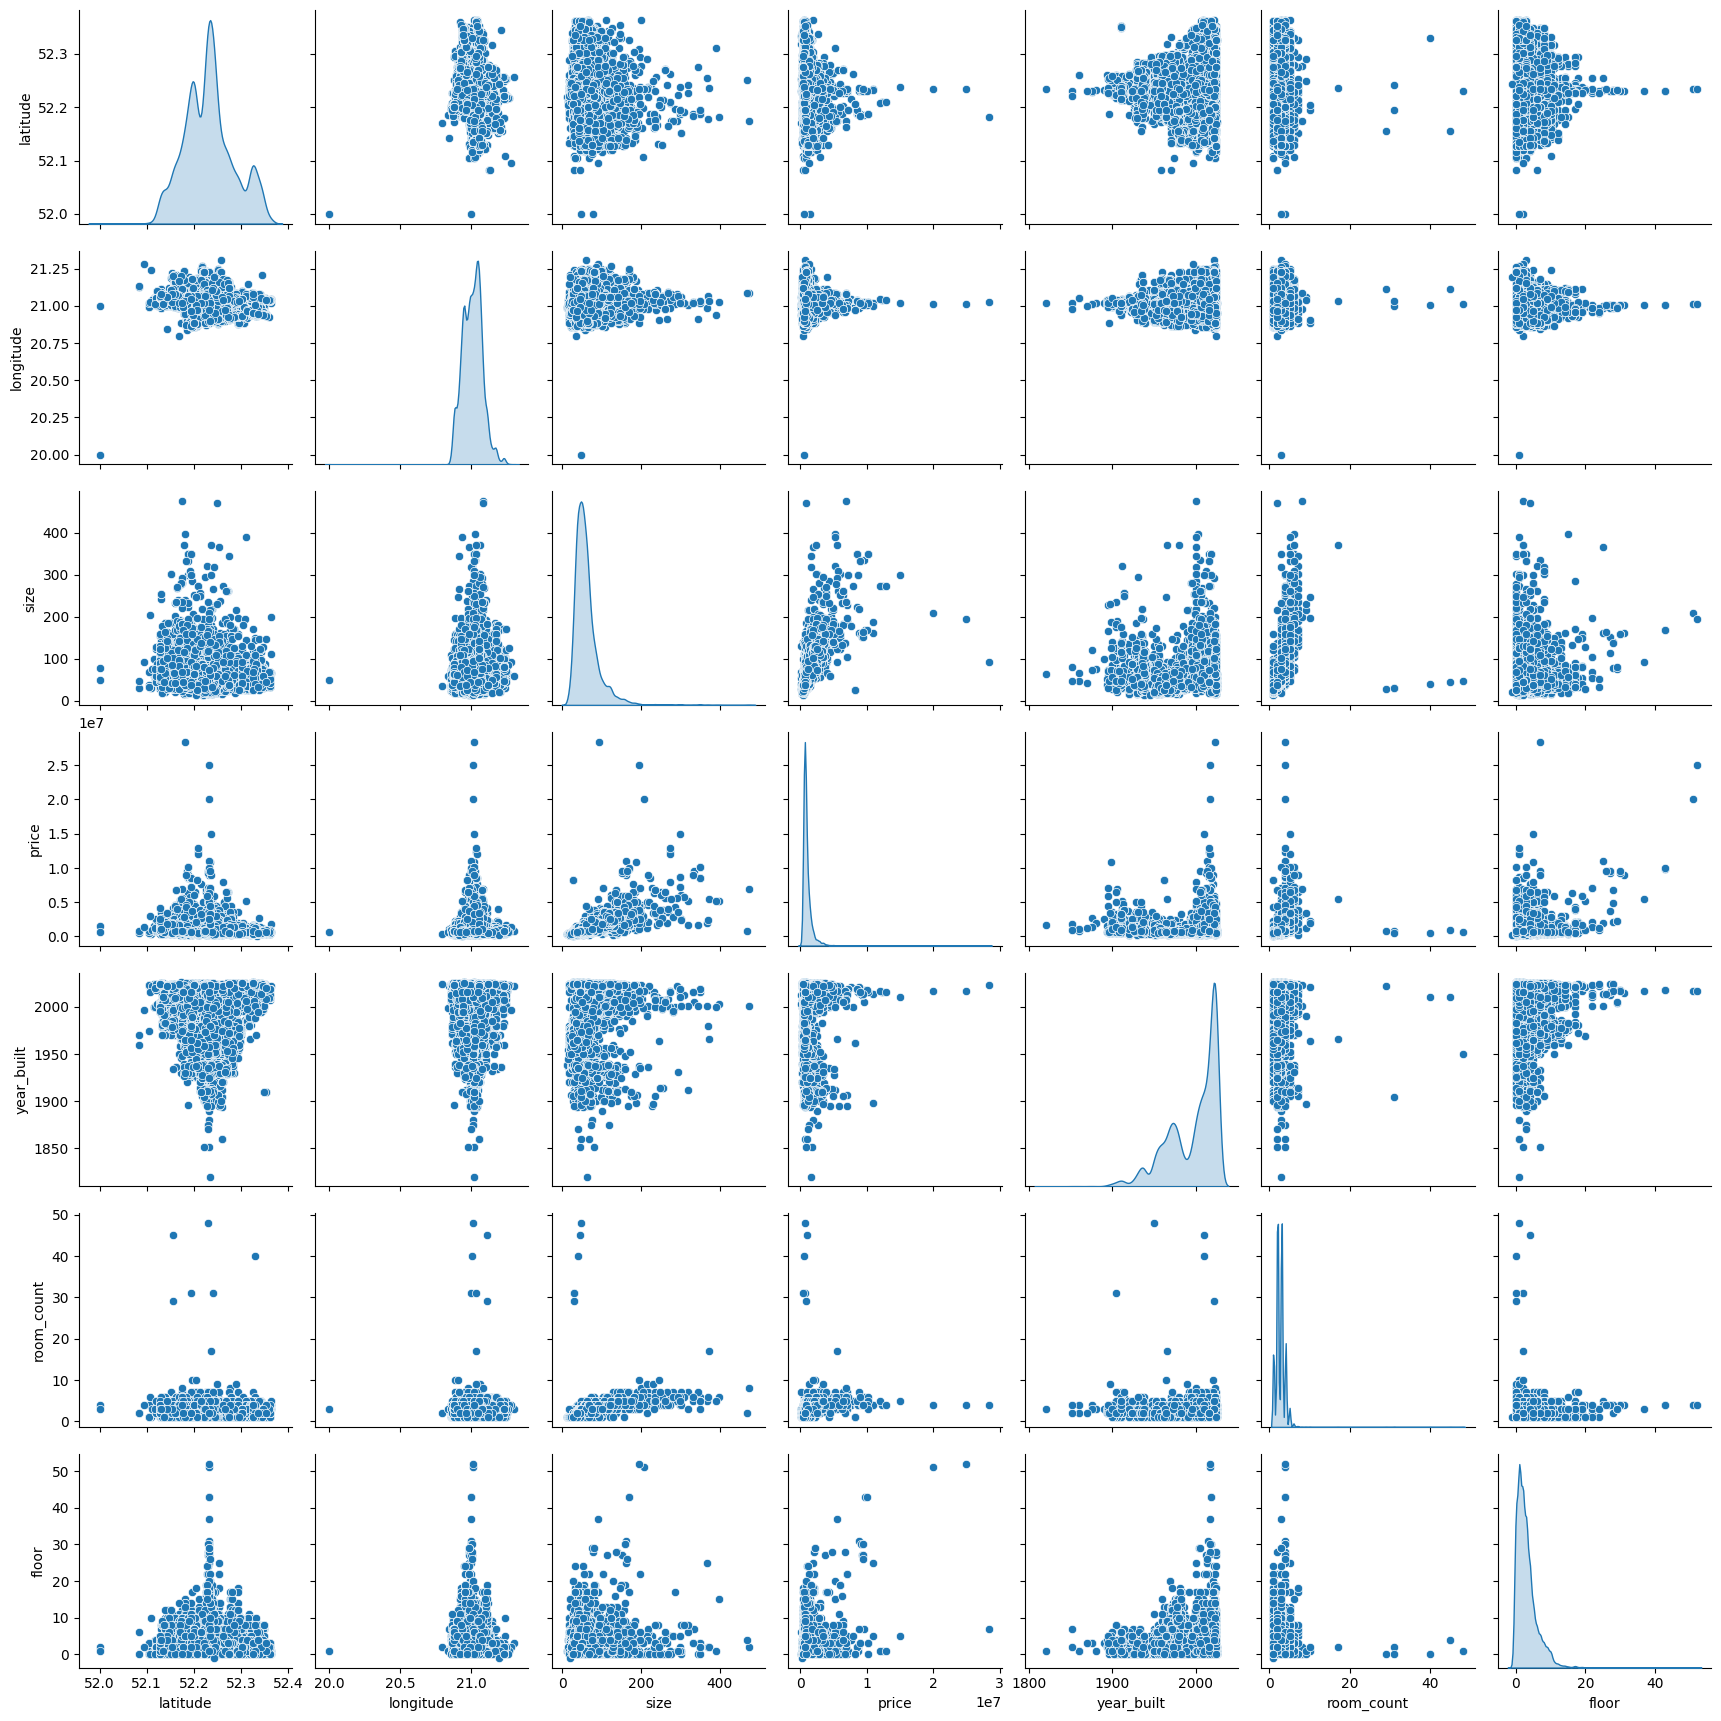

In [88]:
import seaborn as sns

clean_dataframe = clear_dataframe(offers_dataframe)
sns.pairplot(clean_dataframe[['latitude', 'longitude', 'size', 'price', 'year_built', 'room_count', 'floor']], diag_kind='kde')

In [89]:
def split(dataframe):
    train_dataset = dataframe.sample(frac=0.8, random_state=0)
    test_dataset = dataframe.drop(train_dataset.index)

    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_label = train_features.pop('price')
    test_label = test_features.pop('price')

    return train_features, train_label, train_dataset, test_features, test_label, test_dataset


train_features, train_label, train_dataset, test_features, test_label, test_dataset = split(clean_dataframe)

In [90]:

import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

metrics=[
    'mae',
    'mape',
    r_squared,
    tf.metrics.RootMeanSquaredError(),
]

# Linear Regression

In [74]:
import tensorflow as tf

class MeanImputerLayer(tf.keras.layers.Layer):
    def __init__(self, data, **kwargs):
        super(MeanImputerLayer, self).__init__(**kwargs)
        mean_data = data.mean().values
        self.mean_values = tf.Variable(mean_data, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        return tf.where(tf.math.is_nan(inputs), self.mean_values, inputs)


In [75]:
def train_model(train_features, train_label, optimizer, loss_function, epochs, metrics):
    linear_model = tf.keras.Sequential([
        MeanImputerLayer(train_features),
        tf.keras.layers.Dense(units=1)
    ])

    linear_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    linear_model_history = linear_model.fit(
        train_features,
        train_label,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    
    return linear_model, linear_model_history


def evaluate(model, test_features, test_label):
    loss, *metrics = model.evaluate(test_features, test_label)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result


In [76]:
optimizer = tf.keras.optimizers.legacy.Adam
loss_functions = [
    'mean_squared_error',
    'mean_absolute_error'
]
epochs = [
    2_000,
    5_000,
    10_000
]
learning_rates = [
    0.05,
    0.2,
    0.4,
    0.5
]

results_lr = {}

for loss_function in loss_functions:
    for epoch in epochs:
        for learning_rate in learning_rates:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            model, _ = train_model(train_features.copy(), train_label.copy(), optimizer(learning_rate=learning_rate), loss_function, epoch, metrics)
            print(optimizer, loss_function, epoch, learning_rate)
            results_lr[f"{optimizer}, {loss_function}, {epoch}, {learning_rate}"] = evaluate(model, test_features, test_label)
            print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


KeyboardInterrupt: 

In [64]:
sorted_keys_lr = sorted(results_lr, key=lambda k: results_lr[k]['mae'])
for key in sorted_keys_lr:
    print(f"Model: {key}")
    for metric, value in results_lr[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.5
loss: 288807.53125
mae: 288807.53125
mape: 23.23937225341797
r_squared: 0.49477463960647583
root_mean_squared_error: 678203.4375
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.4
loss: 289706.625
mae: 289706.625
mape: 23.12019157409668
r_squared: 0.49324527382850647
root_mean_squared_error: 685113.5625
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 5000, 0.5
loss: 292419.625
mae: 292419.625
mape: 23.22984504699707
r_squared: 0.4863153100013733
root_mean_squared_error: 696856.875
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.2
loss: 293694.34375
mae: 293694.34375
mape: 23.425260543823242
r_squared: 0.48248422145843506
root_mean_squared_error: 700010.3125
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_

# DNN Regression

In [91]:
def train_model_dnn(train_features, train_label, optimizer, loss_function, epochs, metrics, activation):
    linear_model_dnn = tf.keras.Sequential([
        MeanImputerLayer(train_features),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(units=1)
    ])

    linear_model_dnn.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    linear_model_history = linear_model_dnn.fit(
        train_features,
        train_label,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    
    return linear_model_dnn, linear_model_history


def evaluate_dnn(model, test_features, test_label):
    loss, *metrics = model.evaluate(test_features, test_label)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result


In [59]:
optimizers = [
    # tf.keras.optimizers.legacy.SGD,
    tf.keras.optimizers.legacy.RMSprop,
    tf.keras.optimizers.legacy.Adam,
    tf.keras.optimizers.legacy.Adagrad,
    # tf.keras.optimizers.legacy.Adadelta,
    # tf.keras.optimizers.legacy.Ftrl
]
loss_functions = [
    'mean_squared_error',
    'mean_absolute_error'
]
epochs = [
    1_000,
    2_000,
    5_000,
    10_000
]
learning_rates = [
    0.01,
    0.1,
    0.3,
    0.5
]
activation_functions = [
    "elu",
    "exponential",
    "relu",
    "selu",
    "sigmoid",
    "softmax",
    "softplus",
    "softsign",
    "tanh",
    "swish"
]

results_dnn = {}

for loss_function in loss_functions:
    for optimizer in optimizers:
        for epoch in epochs:
            for activation_function in activation_functions:
                for learning_rate in learning_rates:
                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                    model, _ = train_model_dnn(train_features.copy(), train_label.copy(), optimizer(learning_rate=learning_rate), loss_function, epoch, metrics, activation_function)
                    print(optimizer, loss_function, epoch, learning_rate)
                    results_dnn[f"{optimizer}, {loss_function}, {epoch}, {learning_rate} {activation_function}"] = evaluate_dnn(model, test_features.copy(), test_label.copy())
                    print('\n\n\n')


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 389us/step - loss: 292511.5938 - mae: 292511.5938 - mape: 23.2807 - r_squared: 0.4938 - root_mean_squared_error: 673420.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 394us/step - loss: nan - mae: nan - mape: nan - r_squared: nan - root_mean_squared_error: nan




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 391us/step - loss: 450537.5938 - mae: 450537.5938 - mape: 34.4080 - r_squared: -0.1505 - root_mean_squared_error: 1069793.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0

In [61]:
sorted_keys_dnn = sorted(results_dnn, key=lambda k: results_dnn[k]['mae'])
for key in sorted_keys_dnn:
    print(f"Model: {key}")
    for metric, value in results_dnn[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, mean_absolute_error, 2000, 0.3 elu
loss: 292511.59375
mae: 292511.59375
mape: 23.280654907226562
r_squared: 0.4937564432621002
root_mean_squared_error: 673420.75
-----------------
Model: <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, mean_absolute_error, 2000, 0.3 exponential
loss: nan
mae: nan
mape: nan
r_squared: nan
root_mean_squared_error: nan
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_error, 2000, 0.3 selu
loss: 276543.09375
mae: 276543.09375
mape: 22.42282485961914
r_squared: 0.5122087001800537
root_mean_squared_error: 615557.125
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_error, 2000, 0.3 relu
loss: 278858.21875
mae: 278858.21875
mape: 23.49934196472168
r_squared: 0.502552330493927
root_mean_squared_error: 621336.4375
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_

# Random Forest

In [64]:
import tensorflow_decision_forests as tfdf

def train_model_rf(train_dataset, metrics, num_trees, max_num_nodes, max_depth, split_axis, growing_strategy):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset, label='price', task=tfdf.keras.Task.REGRESSION)

    model_rf = tfdf.keras.RandomForestModel(
        num_trees=num_trees,
        max_depth=max_depth,
        max_num_nodes=max_num_nodes,
        split_axis=split_axis,
        growing_strategy=growing_strategy,
        task=tfdf.keras.Task.REGRESSION,
    )

    model_rf.compile(metrics=metrics)

    linear_model_history = model_rf.fit(train_ds, verbose=0)
    
    return model_rf, linear_model_history


def evaluate_rf(model, test_dataset):
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataset, label='price', task=tfdf.keras.Task.REGRESSION)
    loss, *metrics = model.evaluate(test_ds)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result

In [81]:
nums_trees = [100, 300, 900, 1200, 2000] 
max_depths = [4, 8, 16, 32, 64, 128, 512, 1024, 256] # growing_strategy = LOCAL
max_nums_nodes = [4, 16, 64, 128, 256, 512, 1024, 2048, 5096] # growing_strategy = BEST_FIRST_GLOBAL
splits_axis = ['AXIS_ALIGNED', 'SPARSE_OBLIQUE'] 

results_rf = {}

for num_trees in nums_trees:
    for max_depth in max_depths:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_rf(train_dataset.copy(), metrics, num_trees, None, max_depth, split_axis, 'LOCAL')
                results_rf[f"{num_trees}, {max_depth}, {split_axis}, LOCAL"] = evaluate_rf(model, test_dataset.copy())
                print('\n\n\n')
            
for num_trees in nums_trees:
    for max_num_nodes in max_nums_nodes:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_rf(train_dataset.copy(), metrics, num_trees, max_num_nodes, None, split_axis, 'BEST_FIRST_GLOBAL')
                results_rf[f"{num_trees}, {max_num_nodes}, {split_axis}, BEST_FIRST_GLOBAL"] = evaluate_rf(model, test_dataset.copy())
                print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw6otisfn as temporary training directory


[INFO 23-10-08 10:49:06.4925 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw6otisfn/model/ with prefix d7c0d1e9ff2f40a7
[INFO 23-10-08 10:49:06.4981 CEST decision_forest.cc:660] Model loaded with 100 root(s), 1314 node(s), and 6 input feature(s).
[INFO 23-10-08 10:49:06.4982 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:49:06.4982 CEST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 295215.0625 - mape: 27.7988 - r_squared: 0.5164 - root_mean_squared_error: 615027.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo71zsnvf as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 283121.0000 - mape: 26.7962 - r_squared: 0.5508 - root_mean_squared_error: 604920.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu42_79nx as temporary training directory


[INFO 23-10-08 10:49:08.6369 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo71zsnvf/model/ with prefix 9453fcf9efa94796
[INFO 23-10-08 10:49:08.6387 CEST decision_forest.cc:660] Model loaded with 100 root(s), 1338 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:08.6387 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:49:09.1018 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu42_79nx/model/ with prefix cdb64d74ab344f38
[INFO 23-10-08 10:49:09.1178 CEST decision_forest.cc:660] Model loaded with 100 root(s), 14842 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:09.1178 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 194477.7188 - mape: 17.0174 - r_squared: 0.7047 - root_mean_squared_error: 571505.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4y2ux1nt as temporary training directory


[INFO 23-10-08 10:49:11.5559 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4y2ux1nt/model/ with prefix af2c629bf87b4967
[INFO 23-10-08 10:49:11.5758 CEST decision_forest.cc:660] Model loaded with 100 root(s), 14596 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:11.5759 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 186898.0000 - mape: 16.2016 - r_squared: 0.7318 - root_mean_squared_error: 550967.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf1xumdhm as temporary training directory


[INFO 23-10-08 10:49:12.5444 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf1xumdhm/model/ with prefix 7beb4125de214531
[INFO 23-10-08 10:49:12.7295 CEST decision_forest.cc:660] Model loaded with 100 root(s), 126592 node(s), and 8 input feature(s).
[INFO 23-10-08 10:49:12.7295 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143986.6875 - mape: 11.3923 - r_squared: 0.7711 - root_mean_squared_error: 531540.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxlqirncp as temporary training directory


[INFO 23-10-08 10:49:16.7540 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxlqirncp/model/ with prefix 7910064376b74611
[INFO 23-10-08 10:49:16.9174 CEST decision_forest.cc:660] Model loaded with 100 root(s), 124758 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:16.9174 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:16.9174 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143558.0312 - mape: 11.2986 - r_squared: 0.7988 - root_mean_squared_error: 517673.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq_ae9pgh as temporary training directory


[INFO 23-10-08 10:49:17.6547 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq_ae9pgh/model/ with prefix 3905e7e8cb244658
[INFO 23-10-08 10:49:17.7935 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:17.7935 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 506577.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpddr43syy as temporary training directory


[INFO 23-10-08 10:49:22.2615 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpddr43syy/model/ with prefix 3cc27d1a84654157
[INFO 23-10-08 10:49:22.4588 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:22.4589 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 498351.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgq75hrus as temporary training directory


[INFO 23-10-08 10:49:23.1790 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgq75hrus/model/ with prefix e85b99e12df640f6
[INFO 23-10-08 10:49:23.3114 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:23.3115 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 491146.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwd6304oj as temporary training directory


[INFO 23-10-08 10:49:27.5030 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwd6304oj/model/ with prefix 2f66ff3a1a6a40c9
[INFO 23-10-08 10:49:27.6702 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:27.6702 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:27.6703 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 485655.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj67b_hdb as temporary training directory


[INFO 23-10-08 10:49:28.6196 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj67b_hdb/model/ with prefix e90fe241f67740f2
[INFO 23-10-08 10:49:28.9736 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:28.9737 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 480584.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt8ary7o1 as temporary training directory


[INFO 23-10-08 10:49:34.7894 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt8ary7o1/model/ with prefix c40691da6c364e53
[INFO 23-10-08 10:49:34.9649 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:34.9650 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 476667.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt1tpur8j as temporary training directory


[INFO 23-10-08 10:49:35.8038 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt1tpur8j/model/ with prefix aba1570752614112
[INFO 23-10-08 10:49:35.9351 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:35.9351 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 472895.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnc19g_fg as temporary training directory


[INFO 23-10-08 10:49:40.3555 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnc19g_fg/model/ with prefix a25c4b7d01b44976
[INFO 23-10-08 10:49:40.5567 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:40.5567 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:40.5567 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 469967.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp97ga6099 as temporary training directory


[INFO 23-10-08 10:49:41.2167 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp97ga6099/model/ with prefix 67871bb0af6f44d9
[INFO 23-10-08 10:49:41.3603 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:41.3603 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 467045.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_zfi0nun as temporary training directory


[INFO 23-10-08 10:49:45.2549 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_zfi0nun/model/ with prefix 1b972a4cb57c4e6e
[INFO 23-10-08 10:49:45.4118 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:45.4118 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 464778.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeydayr_c as temporary training directory


[INFO 23-10-08 10:49:46.0281 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeydayr_c/model/ with prefix 4cf27d5d8be74843
[INFO 23-10-08 10:49:46.1574 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:46.1575 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 462444.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5ij0qp91 as temporary training directory


[INFO 23-10-08 10:49:50.0327 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5ij0qp91/model/ with prefix 11b9b6cb7f954252
[INFO 23-10-08 10:49:50.1964 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:50.1964 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 460640.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpafr9rey9 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 296038.1562 - mape: 27.7541 - r_squared: 0.5072 - root_mean_squared_error: 469661.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcdo9hz92 as temporary training directory


[INFO 23-10-08 10:49:50.6680 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpafr9rey9/model/ with prefix d7a7c132e8464348
[INFO 23-10-08 10:49:50.6723 CEST decision_forest.cc:660] Model loaded with 300 root(s), 3930 node(s), and 6 input feature(s).
[INFO 23-10-08 10:49:50.6723 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:49:50.6723 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 283686.2188 - mape: 26.8085 - r_squared: 0.5455 - root_mean_squared_error: 475729.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3wi3cr64 as temporary training directory


[INFO 23-10-08 10:49:53.6849 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcdo9hz92/model/ with prefix 6567e2e95e6f4920
[INFO 23-10-08 10:49:53.6894 CEST decision_forest.cc:660] Model loaded with 300 root(s), 4020 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:53.6894 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:49:54.2504 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3wi3cr64/model/ with prefix 78c5dbf0b0254915
[INFO 23-10-08 10:49:54.2891 CEST decision_forest.cc:660] Model loaded with 300 root(s), 44378 node(s), and 8 input feature(s).
[INFO 23-10-08 10:49:54.2892 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 196178.9219 - mape: 17.1508 - r_squared: 0.7081 - root_mean_squared_error: 475021.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw7l5rxn_ as temporary training directory


[INFO 23-10-08 10:50:00.1064 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw7l5rxn_/model/ with prefix f887191342ca4c39
[INFO 23-10-08 10:50:00.1567 CEST decision_forest.cc:660] Model loaded with 300 root(s), 43716 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:00.1567 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 186209.7344 - mape: 16.1495 - r_squared: 0.7362 - root_mean_squared_error: 474065.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwhc9bwcs as temporary training directory


[INFO 23-10-08 10:50:01.2164 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwhc9bwcs/model/ with prefix fda2763c14994f0f
[INFO 23-10-08 10:50:01.6051 CEST decision_forest.cc:660] Model loaded with 300 root(s), 378752 node(s), and 8 input feature(s).
[INFO 23-10-08 10:50:01.6052 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:50:01.6052 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 144105.8125 - mape: 11.3372 - r_squared: 0.7790 - root_mean_squared_error: 472014.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lu7rymm as temporary training directory


[INFO 23-10-08 10:50:11.8111 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lu7rymm/model/ with prefix 7577783df0144aa3
[INFO 23-10-08 10:50:12.2472 CEST decision_forest.cc:660] Model loaded with 300 root(s), 375450 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:12.2472 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:12.2472 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143096.0000 - mape: 11.1782 - r_squared: 0.7942 - root_mean_squared_error: 470173.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdw_4viw8 as temporary training directory


[INFO 23-10-08 10:50:13.4901 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdw_4viw8/model/ with prefix 344c1e8ae50f48c2
[INFO 23-10-08 10:50:13.8754 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:13.8755 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 468396.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyg5dczj1 as temporary training directory


[INFO 23-10-08 10:50:24.5941 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyg5dczj1/model/ with prefix 3464e4eba44444d4
[INFO 23-10-08 10:50:25.0846 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:25.0846 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:25.0846 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 466749.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpizoccspb as temporary training directory


[INFO 23-10-08 10:50:26.3423 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpizoccspb/model/ with prefix 35ecb164fb684530
[INFO 23-10-08 10:50:26.7272 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:26.7272 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 465210.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxhjl3kwg as temporary training directory


[INFO 23-10-08 10:50:38.2345 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxhjl3kwg/model/ with prefix 114f4e1916294b3e
[INFO 23-10-08 10:50:38.7377 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:38.7377 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:38.7377 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 463777.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp782q8xzl as temporary training directory


[INFO 23-10-08 10:50:40.0224 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp782q8xzl/model/ with prefix 40ec336a8b664933
[INFO 23-10-08 10:50:40.4155 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:40.4156 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 462431.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprn6saj9q as temporary training directory


[INFO 23-10-08 10:50:51.4333 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprn6saj9q/model/ with prefix 5462dbf3eb1a4812
[INFO 23-10-08 10:50:51.9127 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:51.9127 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:51.9127 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 461173.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ik8vca9 as temporary training directory


[INFO 23-10-08 10:50:53.2231 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ik8vca9/model/ with prefix 80904d0161c944e6
[INFO 23-10-08 10:50:53.6164 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:53.6164 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 459986.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18lsw1av as temporary training directory


[INFO 23-10-08 10:51:04.9383 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18lsw1av/model/ with prefix a6cd669f7bf6426c
[INFO 23-10-08 10:51:05.4219 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:05.4220 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:05.4220 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 458872.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuv_2umtw as temporary training directory


[INFO 23-10-08 10:51:06.9082 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuv_2umtw/model/ with prefix 59084ed726e74ea5
[INFO 23-10-08 10:51:07.3346 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:51:07.3347 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 457817.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph8ct_eqq as temporary training directory


[INFO 23-10-08 10:51:18.6725 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph8ct_eqq/model/ with prefix f80470b91b9d420f
[INFO 23-10-08 10:51:19.1587 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:19.1587 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:19.1587 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 456825.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprg9mvzbc as temporary training directory


[INFO 23-10-08 10:51:20.4747 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprg9mvzbc/model/ with prefix ea24ec8e3e364299
[INFO 23-10-08 10:51:20.8530 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:51:20.8530 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 455881.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgucm2fma as temporary training directory


[INFO 23-10-08 10:51:32.9661 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgucm2fma/model/ with prefix 4f78d8541826459c
[INFO 23-10-08 10:51:33.5175 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:33.5175 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:33.5175 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 454991.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpooryqugf as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 296512.6562 - mape: 27.8357 - r_squared: 0.4996 - root_mean_squared_error: 460016.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy5xka9pl as temporary training directory


[INFO 23-10-08 10:51:34.4912 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpooryqugf/model/ with prefix 154ff6149d214c43
[INFO 23-10-08 10:51:34.5032 CEST decision_forest.cc:660] Model loaded with 900 root(s), 11692 node(s), and 6 input feature(s).
[INFO 23-10-08 10:51:34.5032 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:51:42.9295 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy5xka9pl/model/ with prefix 060ad4a6677c4b03
[INFO 23-10-08 10:51:42.9438 CEST decision_forest.cc:660] Model loaded with 900 root(s), 12000 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:42.9438 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 283792.8438 - mape: 26.8914 - r_squared: 0.5479 - root_mean_squared_error: 463604.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfjce6opy as temporary training directory


[INFO 23-10-08 10:51:44.1456 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfjce6opy/model/ with prefix 7014a6131d9f4e75
[INFO 23-10-08 10:51:44.2745 CEST decision_forest.cc:660] Model loaded with 900 root(s), 130718 node(s), and 8 input feature(s).
[INFO 23-10-08 10:51:44.2745 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:51:44.2745 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 196404.5156 - mape: 17.1862 - r_squared: 0.7083 - root_mean_squared_error: 463518.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1y0iayg_ as temporary training directory


[INFO 23-10-08 10:52:01.6123 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1y0iayg_/model/ with prefix 94a7adcd633845c0
[INFO 23-10-08 10:52:01.7879 CEST decision_forest.cc:660] Model loaded with 900 root(s), 129590 node(s), and 13 input feature(s).
[INFO 23-10-08 10:52:01.7879 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:52:01.7880 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 186603.0781 - mape: 16.1439 - r_squared: 0.7342 - root_mean_squared_error: 463297.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwqnvuyi_ as temporary training directory


[INFO 23-10-08 10:52:04.5908 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwqnvuyi_/model/ with prefix ef1f4d22c1b945b6
[INFO 23-10-08 10:52:05.6455 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1132802 node(s), and 8 input feature(s).
[INFO 23-10-08 10:52:05.6455 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143799.5625 - mape: 11.3372 - r_squared: 0.7782 - root_mean_squared_error: 462324.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprjlltsbs as temporary training directory


[INFO 23-10-08 10:52:40.4165 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprjlltsbs/model/ with prefix aa728c1fe87e4d92
[INFO 23-10-08 10:52:41.7676 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1120978 node(s), and 13 input feature(s).
[INFO 23-10-08 10:52:41.7676 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:52:41.7676 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143508.3281 - mape: 11.1864 - r_squared: 0.7937 - root_mean_squared_error: 461460.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgf74ker9 as temporary training directory


[INFO 23-10-08 10:52:45.5862 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgf74ker9/model/ with prefix da9c86e289a44774
[INFO 23-10-08 10:52:46.8218 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:52:46.8219 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 460562.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnmsgkw as temporary training directory


[INFO 23-10-08 10:53:25.5322 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnmsgkw/model/ with prefix aa4614a1f59046d3
[INFO 23-10-08 10:53:27.0448 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:53:27.0449 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:53:27.0449 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 459783.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8b2uzy2z as temporary training directory


[INFO 23-10-08 10:53:31.2336 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8b2uzy2z/model/ with prefix 4a46ffaac1c944ee
[INFO 23-10-08 10:53:32.6089 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:53:32.6090 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 458958.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx6vxjk9d as temporary training directory


[INFO 23-10-08 10:54:13.3138 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx6vxjk9d/model/ with prefix d29ee2fa4426484c
[INFO 23-10-08 10:54:14.8663 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:54:14.8663 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:54:14.8663 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 458244.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7glomp8f as temporary training directory


[INFO 23-10-08 10:54:18.8028 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7glomp8f/model/ with prefix 2adf98d8efd04937
[INFO 23-10-08 10:54:20.0176 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:54:20.0176 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 457483.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgqbkaem5 as temporary training directory


[INFO 23-10-08 10:55:03.2700 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgqbkaem5/model/ with prefix 76bd36eb44e34043
[INFO 23-10-08 10:55:04.9266 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:55:04.9267 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:55:04.9267 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 456825.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg4b1qf4i as temporary training directory


[INFO 23-10-08 10:55:09.0375 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg4b1qf4i/model/ with prefix 865a97d8d9274b3d
[INFO 23-10-08 10:55:10.1972 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:55:10.1973 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 456121.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3zfn2dsi as temporary training directory


[INFO 23-10-08 10:55:56.6279 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3zfn2dsi/model/ with prefix 0699beefe4554dc8
[INFO 23-10-08 10:55:58.1665 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:55:58.1665 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:55:58.1665 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 455514.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfinzw5vo as temporary training directory


[INFO 23-10-08 10:56:02.2965 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfinzw5vo/model/ with prefix 65ebb97e01e2460f
[INFO 23-10-08 10:56:03.5992 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:56:03.5992 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 454860.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4fdn4_yz as temporary training directory


[INFO 23-10-08 10:56:49.5501 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4fdn4_yz/model/ with prefix 4729db1ed5714abc
[INFO 23-10-08 10:56:51.0622 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:56:51.0623 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:56:51.0623 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 454299.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgp9shmvc as temporary training directory


[INFO 23-10-08 10:56:55.2386 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgp9shmvc/model/ with prefix dfae09d6bbc544fc
[INFO 23-10-08 10:56:56.4696 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:56:56.4697 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 453690.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjegb0qsi as temporary training directory


[INFO 23-10-08 10:57:42.1571 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjegb0qsi/model/ with prefix d89332e9fddc4fc5
[INFO 23-10-08 10:57:43.8038 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:57:43.8038 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:57:43.8038 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 453169.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevu_2kvz as temporary training directory


[INFO 23-10-08 10:57:45.7151 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevu_2kvz/model/ with prefix 255c99d919d94a65
[INFO 23-10-08 10:57:45.7321 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 15592 node(s), and 6 input feature(s).
[INFO 23-10-08 10:57:45.7321 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 296749.8125 - mape: 27.8293 - r_squared: 0.4973 - root_mean_squared_error: 456685.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp41p8h4s4 as temporary training directory


[INFO 23-10-08 10:58:00.8577 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp41p8h4s4/model/ with prefix 9d875fdf54e94705
[INFO 23-10-08 10:58:00.8844 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 15988 node(s), and 13 input feature(s).
[INFO 23-10-08 10:58:00.8844 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:58:00.8844 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 283829.8750 - mape: 26.8989 - r_squared: 0.5466 - root_mean_squared_error: 459194.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6pz9kz2o as temporary training directory


[INFO 23-10-08 10:58:02.8414 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6pz9kz2o/model/ with prefix f3b40b76d8394ddb
[INFO 23-10-08 10:58:03.0273 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 174284 node(s), and 8 input feature(s).
[INFO 23-10-08 10:58:03.0273 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 196785.3438 - mape: 17.2111 - r_squared: 0.7077 - root_mean_squared_error: 459229.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sxegyz8 as temporary training directory


[INFO 23-10-08 10:58:35.4006 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sxegyz8/model/ with prefix efe41ab3feb548ce
[INFO 23-10-08 10:58:35.6198 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 172640 node(s), and 13 input feature(s).
[INFO 23-10-08 10:58:35.6198 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:58:35.6198 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 186553.4062 - mape: 16.1450 - r_squared: 0.7332 - root_mean_squared_error: 459129.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99rbl3op as temporary training directory


[INFO 23-10-08 10:58:41.3779 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99rbl3op/model/ with prefix d35275affb6a43de
[INFO 23-10-08 10:58:42.9344 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1510014 node(s), and 8 input feature(s).
[INFO 23-10-08 10:58:42.9344 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 144030.3125 - mape: 11.3592 - r_squared: 0.7791 - root_mean_squared_error: 458523.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7779p1s9 as temporary training directory


[INFO 23-10-08 10:59:43.6405 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7779p1s9/model/ with prefix a6865c6de7044eba
[INFO 23-10-08 10:59:45.4316 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1493358 node(s), and 13 input feature(s).
[INFO 23-10-08 10:59:45.4316 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:59:45.4316 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 69ms/step - loss: 0.0000e+00 - mae: 143379.5312 - mape: 11.2029 - r_squared: 0.7945 - root_mean_squared_error: 457938.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdndip1cd as temporary training directory


[INFO 23-10-08 10:59:51.0708 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdndip1cd/model/ with prefix 65c7dfede69445cb
[INFO 23-10-08 10:59:52.6890 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 10:59:52.6891 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 457365.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8k8y8yr4 as temporary training directory


[INFO 23-10-08 11:00:52.6242 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8k8y8yr4/model/ with prefix 75418012b9da4e07
[INFO 23-10-08 11:00:54.6004 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:00:54.6004 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:00:54.6005 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 57ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 456843.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp44w8sh9l as temporary training directory


[INFO 23-10-08 11:01:00.1832 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp44w8sh9l/model/ with prefix e5e9f1918b954689
[INFO 23-10-08 11:01:01.8066 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:01:01.8066 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 456304.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzz4av3ia as temporary training directory


[INFO 23-10-08 11:02:02.8217 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzz4av3ia/model/ with prefix 60ea1b12984f443f
[INFO 23-10-08 11:02:04.9396 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:02:04.9397 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:02:04.9397 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 75ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 455812.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp841395kt as temporary training directory


[INFO 23-10-08 11:02:10.4808 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp841395kt/model/ with prefix 19ec09ba58bf4e0d
[INFO 23-10-08 11:02:12.1367 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:02:12.1368 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 455304.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa7o2914j as temporary training directory


[INFO 23-10-08 11:03:14.0959 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa7o2914j/model/ with prefix 7e115c56f62e4c6c
[INFO 23-10-08 11:03:16.2013 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:03:16.2014 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:03:16.2014 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 69ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 454841.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp824kwbvo as temporary training directory


[INFO 23-10-08 11:03:21.5686 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp824kwbvo/model/ with prefix 45338535d11244fd
[INFO 23-10-08 11:03:23.1759 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:03:23.1759 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 454361.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjgpj5x1 as temporary training directory


[INFO 23-10-08 11:04:20.1945 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjgpj5x1/model/ with prefix 39930f91271b428b
[INFO 23-10-08 11:04:22.1817 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:04:22.1818 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:04:22.1818 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 60ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 453924.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw4xofb5v as temporary training directory


[INFO 23-10-08 11:04:27.4284 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw4xofb5v/model/ with prefix c071dd9847d0454a
[INFO 23-10-08 11:04:29.4124 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:04:29.4126 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 453470.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyyxx9rkc as temporary training directory


[INFO 23-10-08 11:05:27.5896 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyyxx9rkc/model/ with prefix 9201dfbcf5ab4980
[INFO 23-10-08 11:05:30.0579 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:05:30.0580 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:05:30.0580 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 79ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 453057.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczmkzdk4 as temporary training directory


[INFO 23-10-08 11:05:35.4265 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczmkzdk4/model/ with prefix a0e98835e5b44b37
[INFO 23-10-08 11:05:36.9876 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:05:36.9876 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 452627.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7edkktn6 as temporary training directory


[INFO 23-10-08 11:06:33.2372 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7edkktn6/model/ with prefix 6bc7e993bb43486d
[INFO 23-10-08 11:06:35.3624 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:06:35.3624 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:06:35.3624 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 48ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 452237.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvdps2zb9 as temporary training directory


[INFO 23-10-08 11:06:37.8882 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvdps2zb9/model/ with prefix 8cd59cc17db94a8c
[INFO 23-10-08 11:06:37.9142 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 25924 node(s), and 6 input feature(s).
[INFO 23-10-08 11:06:37.9143 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 296626.0625 - mape: 27.7991 - r_squared: 0.4968 - root_mean_squared_error: 454918.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8d0ie1a1 as temporary training directory


[INFO 23-10-08 11:07:01.1287 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8d0ie1a1/model/ with prefix 1b060f2db8e14390
[INFO 23-10-08 11:07:01.1730 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 26676 node(s), and 13 input feature(s).
[INFO 23-10-08 11:07:01.1731 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:07:01.1731 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 283439.8750 - mape: 26.8553 - r_squared: 0.5479 - root_mean_squared_error: 456835.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppjprrnv0 as temporary training directory


[INFO 23-10-08 11:07:04.2477 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppjprrnv0/model/ with prefix ef904c9db9124c09
[INFO 23-10-08 11:07:04.5691 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 290686 node(s), and 8 input feature(s).
[INFO 23-10-08 11:07:04.5691 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 196586.7656 - mape: 17.1995 - r_squared: 0.7087 - root_mean_squared_error: 456879.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppy7zs_6q as temporary training directory


[INFO 23-10-08 11:07:54.0263 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppy7zs_6q/model/ with prefix 35ca08e5143b4844
[INFO 23-10-08 11:07:54.3929 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 289242 node(s), and 13 input feature(s).
[INFO 23-10-08 11:07:54.3929 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:07:54.3929 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 186227.1562 - mape: 16.1008 - r_squared: 0.7355 - root_mean_squared_error: 456824.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvlu6hket as temporary training directory


[INFO 23-10-08 11:08:01.1819 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvlu6hket/model/ with prefix 485b5279172b4430
[INFO 23-10-08 11:08:03.6250 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2520182 node(s), and 8 input feature(s).
[INFO 23-10-08 11:08:03.6251 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143885.7344 - mape: 11.3575 - r_squared: 0.7796 - root_mean_squared_error: 456368.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjihbg8l3 as temporary training directory


[INFO 23-10-08 11:09:32.3155 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjihbg8l3/model/ with prefix 5541d9295a4c46f7
[INFO 23-10-08 11:09:35.4498 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2491216 node(s), and 13 input feature(s).
[INFO 23-10-08 11:09:35.4499 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:09:35.4499 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 87ms/step - loss: 0.0000e+00 - mae: 143200.6094 - mape: 11.1930 - r_squared: 0.7932 - root_mean_squared_error: 455944.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfgfl9e6b as temporary training directory


[INFO 23-10-08 11:09:44.1131 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfgfl9e6b/model/ with prefix 3a1728f7641e44a2
[INFO 23-10-08 11:09:46.9818 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:09:46.9818 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:09:46.9818 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 455507.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppl4_4ncr as temporary training directory


[INFO 23-10-08 11:11:22.0291 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppl4_4ncr/model/ with prefix 9097c64aed424621
[INFO 23-10-08 11:11:25.4089 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:11:25.4089 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:11:25.4089 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 95ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 455107.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpto1ig_yy as temporary training directory


[INFO 23-10-08 11:11:35.1496 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpto1ig_yy/model/ with prefix 0722d990b31b4a0d
[INFO 23-10-08 11:11:37.9124 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:11:37.9124 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:11:37.9124 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 454690.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnzwxidqr as temporary training directory


[INFO 23-10-08 11:13:11.7405 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnzwxidqr/model/ with prefix c5154b9ddf604625
[INFO 23-10-08 11:13:15.1988 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:13:15.1988 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:13:15.1988 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 121ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 454309.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph90lml4m as temporary training directory


[INFO 23-10-08 11:13:23.8916 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph90lml4m/model/ with prefix d39a3f3298534365
[INFO 23-10-08 11:13:26.5156 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:13:26.5156 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:13:26.5156 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 453910.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cpgbyed as temporary training directory


[INFO 23-10-08 11:15:00.9395 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cpgbyed/model/ with prefix 73864b7b400d4ecd
[INFO 23-10-08 11:15:04.2658 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:15:04.2658 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:15:04.2658 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 96ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 453546.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqwuka0bo as temporary training directory


[INFO 23-10-08 11:15:12.9297 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqwuka0bo/model/ with prefix d48f34da463e4915
[INFO 23-10-08 11:15:15.5074 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:15:15.5074 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:15:15.5074 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 453166.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2rp3lv6l as temporary training directory


[INFO 23-10-08 11:16:49.8841 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2rp3lv6l/model/ with prefix 8901d14d5db841c7
[INFO 23-10-08 11:16:53.2812 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:16:53.2813 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:16:53.2813 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 93ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 452818.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp59acxdy0 as temporary training directory


[INFO 23-10-08 11:17:03.7066 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp59acxdy0/model/ with prefix 44ee7f7b14614767
[INFO 23-10-08 11:17:06.4236 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:17:06.4236 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:17:06.4236 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 452454.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfp9f7nkg as temporary training directory


[INFO 23-10-08 11:18:41.3279 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfp9f7nkg/model/ with prefix 1d9faf08cbd74db9
[INFO 23-10-08 11:18:44.7148 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:18:44.7149 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:18:44.7149 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 90ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 452121.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgypqduir as temporary training directory


[INFO 23-10-08 11:18:53.4282 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgypqduir/model/ with prefix c3dc8dc29d694c4c
[INFO 23-10-08 11:18:56.1301 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:18:56.1301 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:18:56.1301 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 451773.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbyn50hdb as temporary training directory


[INFO 23-10-08 11:20:30.6586 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbyn50hdb/model/ with prefix 051c1635e2f84d45
[INFO 23-10-08 11:20:34.1534 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:34.1534 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:34.1534 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 121ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 451454.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp561rvdg as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338341.3438 - mape: 34.2406 - r_squared: 0.4343 - root_mean_squared_error: 454259.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphck8zg21 as temporary training directory


[INFO 23-10-08 11:20:36.8393 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp561rvdg/model/ with prefix c52a170cfddd4c02
[INFO 23-10-08 11:20:36.8401 CEST decision_forest.cc:660] Model loaded with 100 root(s), 700 node(s), and 5 input feature(s).
[INFO 23-10-08 11:20:36.8401 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 326704.9375 - mape: 32.9174 - r_squared: 0.4445 - root_mean_squared_error: 456645.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvd9azer6 as temporary training directory


[INFO 23-10-08 11:20:38.0531 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphck8zg21/model/ with prefix 8f331a3cb17b41ba
[INFO 23-10-08 11:20:38.0542 CEST decision_forest.cc:660] Model loaded with 100 root(s), 700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:38.0542 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 253159.1094 - mape: 24.5857 - r_squared: 0.6484 - root_mean_squared_error: 457114.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yamnxuv as temporary training directory


[INFO 23-10-08 11:20:38.4423 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvd9azer6/model/ with prefix a6ea301bf90341c2
[INFO 23-10-08 11:20:38.4453 CEST decision_forest.cc:660] Model loaded with 100 root(s), 3100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:38.4453 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:20:40.5131 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yamnxuv/model/ with prefix 136a690f441643ea
[INFO 23-10-08 11:20:40.5177 CEST decision_forest.cc:660] Model loaded with 100 root(s), 3100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:40.5177 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 236526.6719 - mape: 22.4156 - r_squared: 0.6531 - root_mean_squared_error: 457606.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpva2x3mca as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 187850.2656 - mape: 17.1789 - r_squared: 0.7301 - root_mean_squared_error: 457419.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bl6b8zf as temporary training directory


[INFO 23-10-08 11:20:41.0033 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpva2x3mca/model/ with prefix 9cf5da8857314cd3
[INFO 23-10-08 11:20:41.0159 CEST decision_forest.cc:660] Model loaded with 100 root(s), 12700 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:41.0159 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:20:44.1716 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bl6b8zf/model/ with prefix aaa04d32ef6d4082
[INFO 23-10-08 11:20:44.1898 CEST decision_forest.cc:660] Model loaded with 100 root(s), 12700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:44.1898 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:44.1899 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 182214.5625 - mape: 16.3567 - r_squared: 0.7454 - root_mean_squared_error: 457350.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmparz3ygw2 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 166313.2812 - mape: 14.5309 - r_squared: 0.7593 - root_mean_squared_error: 457052.7500


[INFO 23-10-08 11:20:44.6770 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmparz3ygw2/model/ with prefix c8d69766b86646ee
[INFO 23-10-08 11:20:44.7022 CEST decision_forest.cc:660] Model loaded with 100 root(s), 25500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:44.7022 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4hx1wvmc as temporary training directory


[INFO 23-10-08 11:20:48.1236 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4hx1wvmc/model/ with prefix 55dff8338eb74195
[INFO 23-10-08 11:20:48.1590 CEST decision_forest.cc:660] Model loaded with 100 root(s), 25500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:48.1590 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 164457.1875 - mape: 13.9823 - r_squared: 0.7621 - root_mean_squared_error: 456908.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppgg4aceg as temporary training directory


[INFO 23-10-08 11:20:48.6914 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppgg4aceg/model/ with prefix 130645e6923947ba
[INFO 23-10-08 11:20:48.7423 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:48.7423 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152626.7656 - mape: 12.6576 - r_squared: 0.7709 - root_mean_squared_error: 456574.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelz4m1mf as temporary training directory


[INFO 23-10-08 11:20:52.9798 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelz4m1mf/model/ with prefix 10b7a28a73704164
[INFO 23-10-08 11:20:53.0487 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:53.0487 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 151943.2500 - mape: 12.3473 - r_squared: 0.7744 - root_mean_squared_error: 456394.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptew6wg55 as temporary training directory


[INFO 23-10-08 11:20:53.6741 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptew6wg55/model/ with prefix 43edd16e9fb24aaa
[INFO 23-10-08 11:20:53.7788 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:53.7788 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145176.1250 - mape: 11.5468 - r_squared: 0.7753 - root_mean_squared_error: 456057.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8s29rk28 as temporary training directory


[INFO 23-10-08 11:20:58.4782 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8s29rk28/model/ with prefix a6a8756dbe204eb2
[INFO 23-10-08 11:20:58.6282 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:58.6282 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:58.6282 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145641.5469 - mape: 11.3763 - r_squared: 0.7763 - root_mean_squared_error: 455875.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf97p3bbm as temporary training directory


[INFO 23-10-08 11:20:59.3356 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf97p3bbm/model/ with prefix 7e26b33dcc744cb6
[INFO 23-10-08 11:20:59.4772 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:20:59.4772 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 455549.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcmgepbq_ as temporary training directory


[INFO 23-10-08 11:21:04.6115 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcmgepbq_/model/ with prefix e64fb6630d2d4263
[INFO 23-10-08 11:21:04.7786 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:04.7786 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 455374.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz662wil3 as temporary training directory


[INFO 23-10-08 11:21:05.4250 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz662wil3/model/ with prefix 993fcc834aea418c
[INFO 23-10-08 11:21:05.5748 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:21:05.5748 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 455058.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdecug3og as temporary training directory


[INFO 23-10-08 11:21:10.6272 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdecug3og/model/ with prefix 758a5439a607445b
[INFO 23-10-08 11:21:10.8059 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:10.8059 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:10.8059 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 454891.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0rvg5fq9 as temporary training directory


[INFO 23-10-08 11:21:11.5142 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0rvg5fq9/model/ with prefix ee3b5bc559034776
[INFO 23-10-08 11:21:11.6430 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:21:11.6430 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 454585.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99y8mksv as temporary training directory


[INFO 23-10-08 11:21:16.6968 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99y8mksv/model/ with prefix 008af4fe401546af
[INFO 23-10-08 11:21:16.8622 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:16.8622 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 454425.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26a3dax_ as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338528.4375 - mape: 34.1134 - r_squared: 0.4252 - root_mean_squared_error: 456782.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb5vbwrn7 as temporary training directory


[INFO 23-10-08 11:21:17.3439 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26a3dax_/model/ with prefix d690bb37d9da4167
[INFO 23-10-08 11:21:17.3459 CEST decision_forest.cc:660] Model loaded with 300 root(s), 2100 node(s), and 6 input feature(s).
[INFO 23-10-08 11:21:17.3459 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 327048.4375 - mape: 32.8447 - r_squared: 0.4481 - root_mean_squared_error: 458809.6250


[INFO 23-10-08 11:21:20.9278 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb5vbwrn7/model/ with prefix 9e8eff021e7749b4
[INFO 23-10-08 11:21:20.9310 CEST decision_forest.cc:660] Model loaded with 300 root(s), 2100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:20.9310 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:20.9310 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp25yfn2ax as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 252944.3906 - mape: 24.4961 - r_squared: 0.6415 - root_mean_squared_error: 459179.7188


[INFO 23-10-08 11:21:21.4963 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp25yfn2ax/model/ with prefix 99d5ed641eea427c
[INFO 23-10-08 11:21:21.5066 CEST decision_forest.cc:660] Model loaded with 300 root(s), 9300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:21.5066 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9hbeoarh as temporary training directory


[INFO 23-10-08 11:21:27.6199 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9hbeoarh/model/ with prefix 288c54297c424328
[INFO 23-10-08 11:21:27.6355 CEST decision_forest.cc:660] Model loaded with 300 root(s), 9300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:27.6356 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 236872.7656 - mape: 22.5173 - r_squared: 0.6583 - root_mean_squared_error: 459499.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt03vhs8b as temporary training directory


[INFO 23-10-08 11:21:28.6555 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt03vhs8b/model/ with prefix e8b833adb9ca4bd0
[INFO 23-10-08 11:21:28.6982 CEST decision_forest.cc:660] Model loaded with 300 root(s), 38100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:28.6983 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 187814.6562 - mape: 17.0960 - r_squared: 0.7308 - root_mean_squared_error: 459331.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yi4rher as temporary training directory


[INFO 23-10-08 11:21:37.8907 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yi4rher/model/ with prefix 9917ad657b6a4111
[INFO 23-10-08 11:21:37.9442 CEST decision_forest.cc:660] Model loaded with 300 root(s), 38100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:37.9442 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:37.9442 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 180851.4531 - mape: 16.2447 - r_squared: 0.7561 - root_mean_squared_error: 459176.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkmrsmpfb as temporary training directory


[INFO 23-10-08 11:21:38.8064 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkmrsmpfb/model/ with prefix 578c63b40b184894
[INFO 23-10-08 11:21:38.8965 CEST decision_forest.cc:660] Model loaded with 300 root(s), 76500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:38.8965 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 166466.7969 - mape: 14.4898 - r_squared: 0.7588 - root_mean_squared_error: 458913.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdwpkrco3 as temporary training directory


[INFO 23-10-08 11:21:48.9326 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdwpkrco3/model/ with prefix 545b3b787bdb4d98
[INFO 23-10-08 11:21:49.0330 CEST decision_forest.cc:660] Model loaded with 300 root(s), 76500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:49.0330 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:49.0330 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 162652.4688 - mape: 13.8566 - r_squared: 0.7739 - root_mean_squared_error: 458691.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp493k18jl as temporary training directory


[INFO 23-10-08 11:21:50.0976 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp493k18jl/model/ with prefix 6d8d485cb17e49f2
[INFO 23-10-08 11:21:50.2608 CEST decision_forest.cc:660] Model loaded with 300 root(s), 153300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:50.2609 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 152142.5625 - mape: 12.5737 - r_squared: 0.7712 - root_mean_squared_error: 458394.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt4wwd038 as temporary training directory


[INFO 23-10-08 11:22:01.8905 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt4wwd038/model/ with prefix cdc3587b059b4ce6
[INFO 23-10-08 11:22:02.0744 CEST decision_forest.cc:660] Model loaded with 300 root(s), 153300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:02.0744 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:02.0744 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 150250.0625 - mape: 12.2284 - r_squared: 0.7845 - root_mean_squared_error: 458146.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpper8hdkm as temporary training directory


[INFO 23-10-08 11:22:03.3629 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpper8hdkm/model/ with prefix e9f96e20a6334b80
[INFO 23-10-08 11:22:03.6946 CEST decision_forest.cc:660] Model loaded with 300 root(s), 306900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:22:03.6946 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144795.1719 - mape: 11.4743 - r_squared: 0.7755 - root_mean_squared_error: 457846.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqmg4z5k4 as temporary training directory


[INFO 23-10-08 11:22:17.0941 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqmg4z5k4/model/ with prefix 61b6d9066df24755
[INFO 23-10-08 11:22:17.4730 CEST decision_forest.cc:660] Model loaded with 300 root(s), 306900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:17.4730 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:17.4731 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143962.0000 - mape: 11.2723 - r_squared: 0.7871 - root_mean_squared_error: 457598.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjdf49vam as temporary training directory


[INFO 23-10-08 11:22:18.8357 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjdf49vam/model/ with prefix 83cd6980a6ea4793
[INFO 23-10-08 11:22:19.2099 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:19.2099 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 457306.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsmdzg6g2 as temporary training directory


[INFO 23-10-08 11:22:33.9191 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsmdzg6g2/model/ with prefix a4b3e0e072644893
[INFO 23-10-08 11:22:34.4224 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:34.4225 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:34.4225 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 457065.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6he62amh as temporary training directory


[INFO 23-10-08 11:22:35.9687 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6he62amh/model/ with prefix c3be016e48cd41e2
[INFO 23-10-08 11:22:36.3495 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:36.3496 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 456783.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprqub4v3a as temporary training directory


[INFO 23-10-08 11:22:51.2189 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprqub4v3a/model/ with prefix 7936d1a44bd94187
[INFO 23-10-08 11:22:51.6969 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:51.6970 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:51.6970 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 456550.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqr64fdxm as temporary training directory


[INFO 23-10-08 11:22:53.2168 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqr64fdxm/model/ with prefix 3359640067954696
[INFO 23-10-08 11:22:53.6108 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:53.6108 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 456276.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp33wwxg6d as temporary training directory


[INFO 23-10-08 11:23:07.6392 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp33wwxg6d/model/ with prefix 19ae36a5b3c64378
[INFO 23-10-08 11:23:08.0947 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:08.0948 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:08.0948 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 456050.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnro2o3 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338061.0000 - mape: 33.9879 - r_squared: 0.4235 - root_mean_squared_error: 458091.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbr2s0h7z as temporary training directory


[INFO 23-10-08 11:23:08.9610 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnro2o3/model/ with prefix 3b2d9ef82a2c4b59
[INFO 23-10-08 11:23:08.9675 CEST decision_forest.cc:660] Model loaded with 900 root(s), 6300 node(s), and 6 input feature(s).
[INFO 23-10-08 11:23:08.9675 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:23:19.0482 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbr2s0h7z/model/ with prefix 4036ea2cdda6451e
[INFO 23-10-08 11:23:19.0572 CEST decision_forest.cc:660] Model loaded with 900 root(s), 6300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:19.0573 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:19.0573 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 328479.0625 - mape: 33.0991 - r_squared: 0.4494 - root_mean_squared_error: 459811.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsm6aem6u as temporary training directory


[INFO 23-10-08 11:23:20.1367 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsm6aem6u/model/ with prefix 519eaf4b8662481b
[INFO 23-10-08 11:23:20.1689 CEST decision_forest.cc:660] Model loaded with 900 root(s), 27900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:23:20.1690 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 252533.2969 - mape: 24.4453 - r_squared: 0.6426 - root_mean_squared_error: 460124.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu8112ts_ as temporary training directory


[INFO 23-10-08 11:23:38.0489 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu8112ts_/model/ with prefix 3bae6672c836418c
[INFO 23-10-08 11:23:38.0876 CEST decision_forest.cc:660] Model loaded with 900 root(s), 27900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:38.0877 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:38.0877 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 236919.8125 - mape: 22.5698 - r_squared: 0.6589 - root_mean_squared_error: 460384.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2sizeh_u as temporary training directory


[INFO 23-10-08 11:23:39.7699 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2sizeh_u/model/ with prefix ce623bb26a354dff
[INFO 23-10-08 11:23:39.9022 CEST decision_forest.cc:660] Model loaded with 900 root(s), 114300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:23:39.9023 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 187274.9688 - mape: 17.0525 - r_squared: 0.7345 - root_mean_squared_error: 460225.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyve1lwya as temporary training directory


[INFO 23-10-08 11:24:05.6472 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyve1lwya/model/ with prefix cb348ecb4fc643e5
[INFO 23-10-08 11:24:05.7923 CEST decision_forest.cc:660] Model loaded with 900 root(s), 114300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:24:05.7923 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:24:05.7923 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 180362.6875 - mape: 16.2156 - r_squared: 0.7593 - root_mean_squared_error: 460068.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0q3kxbe1 as temporary training directory


[INFO 23-10-08 11:24:07.7581 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0q3kxbe1/model/ with prefix 17d48bc122094e95
[INFO 23-10-08 11:24:07.9908 CEST decision_forest.cc:660] Model loaded with 900 root(s), 229500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:24:07.9909 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 165967.0938 - mape: 14.4408 - r_squared: 0.7605 - root_mean_squared_error: 459828.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv6i7j_uz as temporary training directory


[INFO 23-10-08 11:24:38.0791 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv6i7j_uz/model/ with prefix 81e1c473b1c44b06
[INFO 23-10-08 11:24:38.3667 CEST decision_forest.cc:660] Model loaded with 900 root(s), 229500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:24:38.3667 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:24:38.3667 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mae: 162202.1094 - mape: 13.8096 - r_squared: 0.7777 - root_mean_squared_error: 459612.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0adagvj3 as temporary training directory


[INFO 23-10-08 11:24:40.8843 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0adagvj3/model/ with prefix 45a4dc2a93f148e5
[INFO 23-10-08 11:24:41.3323 CEST decision_forest.cc:660] Model loaded with 900 root(s), 459900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:24:41.3323 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 151602.4531 - mape: 12.5204 - r_squared: 0.7739 - root_mean_squared_error: 459342.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja2sd8et as temporary training directory


[INFO 23-10-08 11:25:14.9873 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja2sd8et/model/ with prefix 5b64bf8740514af4
[INFO 23-10-08 11:25:15.5307 CEST decision_forest.cc:660] Model loaded with 900 root(s), 459900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:25:15.5307 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:25:15.5307 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 149900.1250 - mape: 12.1855 - r_squared: 0.7882 - root_mean_squared_error: 459104.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9114i1fo as temporary training directory


[INFO 23-10-08 11:25:18.9151 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9114i1fo/model/ with prefix fae38b27a7af4b2e
[INFO 23-10-08 11:25:19.7803 CEST decision_forest.cc:660] Model loaded with 900 root(s), 920700 node(s), and 7 input feature(s).
[INFO 23-10-08 11:25:19.7803 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 144112.8906 - mape: 11.4036 - r_squared: 0.7780 - root_mean_squared_error: 458831.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18mdlfnl as temporary training directory


[INFO 23-10-08 11:25:59.5113 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18mdlfnl/model/ with prefix df62d2a9e6404a83
[INFO 23-10-08 11:26:00.6190 CEST decision_forest.cc:660] Model loaded with 900 root(s), 920700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:26:00.6191 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:26:00.6191 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143550.5469 - mape: 11.2157 - r_squared: 0.7910 - root_mean_squared_error: 458592.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ngutp7y as temporary training directory


[INFO 23-10-08 11:26:04.6565 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ngutp7y/model/ with prefix aaa09e872ff44235
[INFO 23-10-08 11:26:05.7653 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:26:05.7653 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 458326.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsfpel415 as temporary training directory


[INFO 23-10-08 11:26:47.7647 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsfpel415/model/ with prefix 64b5efc5cef0490a
[INFO 23-10-08 11:26:49.1852 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:26:49.1852 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:26:49.1852 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 458093.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphcdhcdvj as temporary training directory


[INFO 23-10-08 11:26:53.1700 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphcdhcdvj/model/ with prefix 5d72c9b4f16f4314
[INFO 23-10-08 11:26:54.2856 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:26:54.2857 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 457833.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz37z8kz as temporary training directory


[INFO 23-10-08 11:27:37.3354 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz37z8kz/model/ with prefix 8edc478d5c374030
[INFO 23-10-08 11:27:38.7823 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:27:38.7824 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:27:38.7824 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 457607.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkgg5rjid as temporary training directory


[INFO 23-10-08 11:27:42.6775 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkgg5rjid/model/ with prefix c14faae2828946d7
[INFO 23-10-08 11:27:43.8863 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:27:43.8863 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 457354.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprbzjee07 as temporary training directory


[INFO 23-10-08 11:28:24.5145 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprbzjee07/model/ with prefix c182ba2231934508
[INFO 23-10-08 11:28:25.9395 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:28:25.9396 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:28:25.9396 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 457134.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoqw9pods as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 337840.1562 - mape: 33.9088 - r_squared: 0.4236 - root_mean_squared_error: 458933.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdywbyt4q as temporary training directory


[INFO 23-10-08 11:28:27.6512 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoqw9pods/model/ with prefix d76e0aa5fe0c4233
[INFO 23-10-08 11:28:27.6616 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 8400 node(s), and 6 input feature(s).
[INFO 23-10-08 11:28:27.6616 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:28:41.0148 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdywbyt4q/model/ with prefix 32f1c91809a5430e
[INFO 23-10-08 11:28:41.0275 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 8400 node(s), and 13 input feature(s).
[INFO 23-10-08 11:28:41.0276 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:28:41.0276 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 328367.3438 - mape: 33.0843 - r_squared: 0.4478 - root_mean_squared_error: 460435.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp8bqlk89 as temporary training directory


[INFO 23-10-08 11:28:42.3389 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp8bqlk89/model/ with prefix 8a777fab5efe4b07
[INFO 23-10-08 11:28:42.3827 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 37200 node(s), and 7 input feature(s).
[INFO 23-10-08 11:28:42.3828 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 252650.0938 - mape: 24.4458 - r_squared: 0.6421 - root_mean_squared_error: 460712.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms9xtttc as temporary training directory


[INFO 23-10-08 11:29:04.7836 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms9xtttc/model/ with prefix 95696e7678524937
[INFO 23-10-08 11:29:04.8361 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 37200 node(s), and 13 input feature(s).
[INFO 23-10-08 11:29:04.8361 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:29:04.8361 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 237088.0938 - mape: 22.5974 - r_squared: 0.6582 - root_mean_squared_error: 460929.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvejln8oj as temporary training directory


[INFO 23-10-08 11:29:06.9093 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvejln8oj/model/ with prefix ec6090eca377497b
[INFO 23-10-08 11:29:07.0808 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 152400 node(s), and 7 input feature(s).
[INFO 23-10-08 11:29:07.0808 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 187264.8125 - mape: 17.0473 - r_squared: 0.7336 - root_mean_squared_error: 460790.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxwkrywr_ as temporary training directory


[INFO 23-10-08 11:29:40.2593 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxwkrywr_/model/ with prefix 9feab4ebdad849c0
[INFO 23-10-08 11:29:40.4608 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 152400 node(s), and 13 input feature(s).
[INFO 23-10-08 11:29:40.4609 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:29:40.4609 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 180402.4219 - mape: 16.2333 - r_squared: 0.7579 - root_mean_squared_error: 460641.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk_xpo6zl as temporary training directory


[INFO 23-10-08 11:29:43.2038 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk_xpo6zl/model/ with prefix 510763abc9764d3d
[INFO 23-10-08 11:29:43.5067 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 306000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:29:43.5068 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 166001.4375 - mape: 14.4430 - r_squared: 0.7599 - root_mean_squared_error: 460431.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr571cjv9 as temporary training directory


[INFO 23-10-08 11:30:21.8622 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr571cjv9/model/ with prefix 4b5d70930d2145c8
[INFO 23-10-08 11:30:22.2357 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 306000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:30:22.2357 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:30:22.2357 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 162260.0781 - mape: 13.8296 - r_squared: 0.7761 - root_mean_squared_error: 460230.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6gr27tx as temporary training directory


[INFO 23-10-08 11:30:25.6428 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6gr27tx/model/ with prefix 93428f03ec994eae
[INFO 23-10-08 11:30:26.2633 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 613200 node(s), and 7 input feature(s).
[INFO 23-10-08 11:30:26.2634 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 151670.7344 - mape: 12.5261 - r_squared: 0.7731 - root_mean_squared_error: 459992.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_go90qji as temporary training directory


[INFO 23-10-08 11:31:05.4732 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_go90qji/model/ with prefix 8c348b1d62bc451d
[INFO 23-10-08 11:31:06.2564 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 613200 node(s), and 13 input feature(s).
[INFO 23-10-08 11:31:06.2564 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:31:06.2564 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - mae: 149994.7969 - mape: 12.2097 - r_squared: 0.7868 - root_mean_squared_error: 459771.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpud1_utca as temporary training directory


[INFO 23-10-08 11:31:10.1760 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpud1_utca/model/ with prefix d31b51356b374b08
[INFO 23-10-08 11:31:11.3656 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1227600 node(s), and 7 input feature(s).
[INFO 23-10-08 11:31:11.3656 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 144165.5781 - mape: 11.4059 - r_squared: 0.7771 - root_mean_squared_error: 459529.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_0frme3y as temporary training directory


[INFO 23-10-08 11:31:55.9616 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_0frme3y/model/ with prefix a05ebdecde8045d0
[INFO 23-10-08 11:31:57.4292 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1227600 node(s), and 13 input feature(s).
[INFO 23-10-08 11:31:57.4292 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:31:57.4292 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 60ms/step - loss: 0.0000e+00 - mae: 143647.7812 - mape: 11.2410 - r_squared: 0.7895 - root_mean_squared_error: 459307.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi4qora12 as temporary training directory


[INFO 23-10-08 11:32:02.1081 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi4qora12/model/ with prefix def195ed7dc546b4
[INFO 23-10-08 11:32:03.6500 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:32:03.6501 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 459071.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4kosxi0 as temporary training directory


[INFO 23-10-08 11:32:50.1687 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4kosxi0/model/ with prefix 5440e744b7dc46f0
[INFO 23-10-08 11:32:52.0488 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:32:52.0489 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:32:52.0489 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 49ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 458853.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm9sgd32q as temporary training directory


[INFO 23-10-08 11:32:56.7690 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm9sgd32q/model/ with prefix a4eedfd4227747cd
[INFO 23-10-08 11:32:58.3025 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:32:58.3026 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 458623.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6rang4_ as temporary training directory


[INFO 23-10-08 11:33:44.8339 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6rang4_/model/ with prefix ae791d2f6a394d62
[INFO 23-10-08 11:33:46.7899 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:33:46.7899 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:33:46.7900 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 44ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 458410.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwa_vz_so as temporary training directory


[INFO 23-10-08 11:33:51.4351 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwa_vz_so/model/ with prefix 596321b1564a4a8b
[INFO 23-10-08 11:33:52.9374 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:33:52.9374 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 458185.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp87hoei5o as temporary training directory


[INFO 23-10-08 11:34:38.9843 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp87hoei5o/model/ with prefix 461b02f0e2e74a85
[INFO 23-10-08 11:34:40.9006 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:34:40.9007 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:34:40.9007 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 45ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 457978.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6g44gon as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 338112.2188 - mape: 33.9476 - r_squared: 0.4249 - root_mean_squared_error: 459568.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3pdh4y5l as temporary training directory


[INFO 23-10-08 11:34:43.0831 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6g44gon/model/ with prefix c90b0a44c4664373
[INFO 23-10-08 11:34:43.0960 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 14000 node(s), and 6 input feature(s).
[INFO 23-10-08 11:34:43.0960 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:35:00.8597 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3pdh4y5l/model/ with prefix 2518bc4343ad4cdb
[INFO 23-10-08 11:35:00.8777 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 14000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:35:00.8777 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:35:00.8777 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 328525.4375 - mape: 33.1268 - r_squared: 0.4494 - root_mean_squared_error: 460884.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7hoyaqc3 as temporary training directory


[INFO 23-10-08 11:35:02.6185 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7hoyaqc3/model/ with prefix 0ac6babd64094b6b
[INFO 23-10-08 11:35:02.6809 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 62000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:35:02.6809 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 252308.9844 - mape: 24.4110 - r_squared: 0.6432 - root_mean_squared_error: 461123.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpav53takj as temporary training directory


[INFO 23-10-08 11:35:34.4840 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpav53takj/model/ with prefix 17daf1c2a2314e1c
[INFO 23-10-08 11:35:34.5694 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 62000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:35:34.5695 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:35:34.5695 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mae: 236563.0625 - mape: 22.5668 - r_squared: 0.6624 - root_mean_squared_error: 461305.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk6r_4ymj as temporary training directory


[INFO 23-10-08 11:35:37.4981 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk6r_4ymj/model/ with prefix a49db5a81683471e
[INFO 23-10-08 11:35:37.7634 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 254000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:35:37.7634 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 186969.2031 - mape: 17.0332 - r_squared: 0.7350 - root_mean_squared_error: 461176.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg2br5n3j as temporary training directory


[INFO 23-10-08 11:36:23.9156 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg2br5n3j/model/ with prefix 5e82de66f6f243ab
[INFO 23-10-08 11:36:24.2430 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 254000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:36:24.2431 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:36:24.2431 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 180167.1562 - mape: 16.2265 - r_squared: 0.7609 - root_mean_squared_error: 461037.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtuk36jm as temporary training directory


[INFO 23-10-08 11:36:28.0290 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtuk36jm/model/ with prefix 3325ba9282834f10
[INFO 23-10-08 11:36:28.9526 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 510000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:36:28.9564 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 165847.4062 - mape: 14.4442 - r_squared: 0.7618 - root_mean_squared_error: 460844.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vaer7m5 as temporary training directory


[INFO 23-10-08 11:37:22.7420 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vaer7m5/model/ with prefix d753c59fe604488b
[INFO 23-10-08 11:37:23.3985 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 510000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:37:23.3986 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:37:23.3986 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - mae: 162023.4219 - mape: 13.8280 - r_squared: 0.7790 - root_mean_squared_error: 460658.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrzqseg0 as temporary training directory


[INFO 23-10-08 11:37:28.1281 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrzqseg0/model/ with prefix 5e3ce97c57d34b48
[INFO 23-10-08 11:37:29.4872 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 1022000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:37:29.4882 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 151476.1719 - mape: 12.5203 - r_squared: 0.7751 - root_mean_squared_error: 460441.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu6pmz4ek as temporary training directory


[INFO 23-10-08 11:38:42.9677 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu6pmz4ek/model/ with prefix cc79f3e89ca64b48
[INFO 23-10-08 11:38:44.1961 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 1022000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:38:44.1962 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:38:44.1962 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 67ms/step - loss: 0.0000e+00 - mae: 149670.2500 - mape: 12.1988 - r_squared: 0.7899 - root_mean_squared_error: 460236.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnlqpvw5u as temporary training directory


[INFO 23-10-08 11:38:51.1335 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnlqpvw5u/model/ with prefix 5c5a4e188dbe4d2e
[INFO 23-10-08 11:38:53.1135 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2046000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:38:53.1136 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - mae: 144057.2344 - mape: 11.4061 - r_squared: 0.7791 - root_mean_squared_error: 460016.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptoeq2kf5 as temporary training directory


[INFO 23-10-08 11:40:14.5132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptoeq2kf5/model/ with prefix 979a19766fc54e88
[INFO 23-10-08 11:40:17.2194 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2046000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:40:17.2195 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:40:17.2195 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 101ms/step - loss: 0.0000e+00 - mae: 143316.3906 - mape: 11.2293 - r_squared: 0.7926 - root_mean_squared_error: 459809.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqfjcolwi as temporary training directory


[INFO 23-10-08 11:40:27.1251 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqfjcolwi/model/ with prefix c9958a44571b499f
[INFO 23-10-08 11:40:30.3106 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:40:30.3107 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:40:30.3107 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 459593.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4bz1u39_ as temporary training directory


[INFO 23-10-08 11:41:55.9071 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4bz1u39_/model/ with prefix 2fef14b424fc4e1e
[INFO 23-10-08 11:41:59.4861 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:41:59.4861 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:41:59.4862 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 98ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 459390.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppni0qd6q as temporary training directory


[INFO 23-10-08 11:42:08.1091 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppni0qd6q/model/ with prefix 580db57832424632
[INFO 23-10-08 11:42:10.6116 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:42:10.6116 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:42:10.6117 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 459178.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6h371ea3 as temporary training directory


[INFO 23-10-08 11:43:34.6698 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6h371ea3/model/ with prefix 04e4adf79540448b
[INFO 23-10-08 11:43:37.9713 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:43:37.9714 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:43:37.9714 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 120ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 458980.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bgv0jbu as temporary training directory


[INFO 23-10-08 11:43:47.1288 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bgv0jbu/model/ with prefix f83711c549f94e3b
[INFO 23-10-08 11:43:49.7808 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:43:49.7808 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:43:49.7808 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 458773.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti7zti_o as temporary training directory


[INFO 23-10-08 11:45:16.0733 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti7zti_o/model/ with prefix 9cddec4829254773
[INFO 23-10-08 11:45:19.5637 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:45:19.5637 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:45:19.5637 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 102ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 458579.6562






In [62]:
sorted_keys_rf = sorted(results_rf, key=lambda k: results_rf[k]['mae'])
for key in sorted_keys_rf:
    print(f"Model: {key}")
    for metric, value in results_rf[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

NameError: name 'results5' is not defined

# Gradient Boosted Trees

In [92]:
import tensorflow_decision_forests as tfdf

def train_model_gbt(train_dataset, metrics, num_trees, max_num_nodes, max_depth, split_axis, growing_strategy):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset, label='price', task=tfdf.keras.Task.REGRESSION)

    model_gbt = tfdf.keras.GradientBoostedTreesModel(
        num_trees=num_trees,
        max_depth=max_depth,
        max_num_nodes=max_num_nodes,
        split_axis=split_axis,
        growing_strategy=growing_strategy,
        task=tfdf.keras.Task.REGRESSION,
    )

    model_gbt.compile(metrics=metrics)

    linear_model_history = model_gbt.fit(train_ds, verbose=0)
    
    return model_gbt, linear_model_history


def evaluate_gbt(model, test_dataset):
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataset, label='price', task=tfdf.keras.Task.REGRESSION)
    loss, *metrics = model.evaluate(test_ds)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result

In [93]:
nums_trees = [100, 300, 900, 1200, 2000] 
max_depths = [4, 8, 16, 32, 64, 128, 512, 1024, 256] # growing_strategy = LOCAL
max_nums_nodes = [4, 16, 64, 128, 256, 512, 1024, 2048, 5096] # growing_strategy = BEST_FIRST_GLOBAL
splits_axis = ['AXIS_ALIGNED', 'SPARSE_OBLIQUE'] 

results_gbt = {}

for num_trees in nums_trees:
    for max_depth in max_depths:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_gbt(train_dataset.copy(), metrics, num_trees, None, max_depth, split_axis, 'LOCAL')
                results_gbt[f"{num_trees}, {max_depth}, {split_axis}, LOCAL"] = evaluate_gbt(model, test_dataset.copy())
                print('\n\n\n')
            
for num_trees in nums_trees:
    for max_num_nodes in max_nums_nodes:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_gbt(train_dataset.copy(), metrics, num_trees, max_num_nodes, None, split_axis, 'BEST_FIRST_GLOBAL')
                results_gbt[f"{num_trees}, {max_num_nodes}, {split_axis}, BEST_FIRST_GLOBAL"] = evaluate_gbt(model, test_dataset.copy())
                print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm0g0hh5e as temporary training directory


[WARNING 23-10-20 21:20:06.7245 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:06.7259 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:06.7259 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:07.9217 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm0g0hh5e/model/ with prefix eb6f3f0d43eb40c1
[INFO 23-10-20 21:20:07.9287 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-20 21:20:07.9287 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 171784.9062 - mape: 15.6953 - r_squared: 0.6930 - root_mean_squared_error: 390386.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc6jxuv1m as temporary training directory


[WARNING 23-10-20 21:20:08.4123 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:08.4124 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:08.4124 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:11.6009 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc6jxuv1m/model/ with prefix e49f3c3219f041fa
[INFO 23-10-20 21:20:11.6029 CEST decision_forest.cc:660] Model loaded with 88 root(s), 1278 node(s), and 13 input feature(s).
[INFO 23-10-20 21:20:11.6029 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 163585.7969 - mape: 14.7592 - r_squared: 0.7279 - root_mean_squared_error: 380140.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1pqu6rfk as temporary training directory


[WARNING 23-10-20 21:20:11.8809 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:11.8810 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:11.8810 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:13.0462 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1pqu6rfk/model/ with prefix 9d9b90d3ce6448c1
[INFO 23-10-20 21:20:13.0588 CEST decision_forest.cc:660] Model loaded with 100 root(s), 8658 node(s), and 7 input feature(s).
[INFO 23-10-20 21:20:13.0588 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141257.2812 - mape: 12.6002 - r_squared: 0.7760 - root_mean_squared_error: 364827.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqpekl6aq as temporary training directory


[WARNING 23-10-20 21:20:13.3564 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:13.3564 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:13.3564 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:20.6367 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqpekl6aq/model/ with prefix 3e4b407897fa4869
[INFO 23-10-20 21:20:20.6540 CEST decision_forest.cc:660] Model loaded with 98 root(s), 9008 node(s), and 13 input feature(s).
[INFO 23-10-20 21:20:20.6540 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:20:20.6540 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 137810.2969 - mape: 12.1588 - r_squared: 0.7880 - root_mean_squared_error: 356493.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp787r50ru as temporary training directory


[WARNING 23-10-20 21:20:20.9982 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:20.9982 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:20.9982 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:24.5864 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp787r50ru/model/ with prefix 6a3e3f850bd246a1
[INFO 23-10-20 21:20:24.6562 CEST decision_forest.cc:660] Model loaded with 38 root(s), 67516 node(s), and 7 input feature(s).
[INFO 23-10-20 21:20:24.6563 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 127088.7891 - mape: 10.9000 - r_squared: 0.7898 - root_mean_squared_error: 351738.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkva4d0cy as temporary training directory


[WARNING 23-10-20 21:20:24.9373 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:24.9373 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:24.9373 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:43.3441 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkva4d0cy/model/ with prefix 13b82d6f08ce4442
[INFO 23-10-20 21:20:43.4320 CEST decision_forest.cc:660] Model loaded with 68 root(s), 60592 node(s), and 13 input feature(s).
[INFO 23-10-20 21:20:43.4320 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:20:43.4320 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122711.9531 - mape: 10.5332 - r_squared: 0.7996 - root_mean_squared_error: 347848.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0p_kv682 as temporary training directory


[WARNING 23-10-20 21:20:43.7495 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:43.7495 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:43.7495 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:20:53.2922 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0p_kv682/model/ with prefix 01741ab351774a60
[INFO 23-10-20 21:20:53.4656 CEST decision_forest.cc:660] Model loaded with 72 root(s), 175982 node(s), and 8 input feature(s).
[INFO 23-10-20 21:20:53.4657 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:20:53.4657 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 122067.2188 - mape: 10.4969 - r_squared: 0.8117 - root_mean_squared_error: 343530.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdtfd936w as temporary training directory


[WARNING 23-10-20 21:20:53.7101 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:53.7101 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:20:53.7102 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:21:22.2080 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdtfd936w/model/ with prefix 1acf37cd19d245e2
[INFO 23-10-20 21:21:22.3783 CEST decision_forest.cc:660] Model loaded with 55 root(s), 135299 node(s), and 13 input feature(s).
[INFO 23-10-20 21:21:22.3783 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:21:22.3783 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117564.8984 - mape: 10.1751 - r_squared: 0.8038 - root_mean_squared_error: 341607.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpagjd5eba as temporary training directory


[WARNING 23-10-20 21:21:22.7165 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:21:22.7167 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:21:22.7167 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:21:32.2295 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpagjd5eba/model/ with prefix f66633abae2343a0
[INFO 23-10-20 21:21:32.3614 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:21:32.3614 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 339871.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvvvj3ayx as temporary training directory


[WARNING 23-10-20 21:21:32.5967 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:21:32.5967 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:21:32.5967 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:22:08.7980 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvvvj3ayx/model/ with prefix 3a8c616115e4424c
[INFO 23-10-20 21:22:08.9765 CEST decision_forest.cc:660] Model loaded with 48 root(s), 146154 node(s), and 13 input feature(s).
[INFO 23-10-20 21:22:08.9765 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:22:08.9765 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 116912.1250 - mape: 10.1540 - r_squared: 0.8116 - root_mean_squared_error: 337926.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8q7ucarg as temporary training directory


[WARNING 23-10-20 21:22:09.3024 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:09.3024 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:09.3024 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:22:19.2081 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8q7ucarg/model/ with prefix 155677fe24654f3c
[INFO 23-10-20 21:22:19.3342 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:22:19.3342 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:22:19.3342 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 336828.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bnraq4u as temporary training directory


[WARNING 23-10-20 21:22:19.5702 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:19.5703 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:19.5703 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:22:57.6952 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bnraq4u/model/ with prefix 014c65d3cbaa42a3
[INFO 23-10-20 21:22:57.8706 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:22:57.8707 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:22:57.8707 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 335457.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpunktqa0p as temporary training directory


[WARNING 23-10-20 21:22:58.1811 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:58.1811 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:22:58.1811 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:23:08.3979 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpunktqa0p/model/ with prefix f9f90c61916b471d
[INFO 23-10-20 21:23:08.5236 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:23:08.5237 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:23:08.5237 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 334712.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevwqbdtm as temporary training directory


[WARNING 23-10-20 21:23:08.7458 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:08.7458 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:08.7458 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:23:47.6373 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevwqbdtm/model/ with prefix 026c8f0dcb434432
[INFO 23-10-20 21:23:47.8162 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:23:47.8162 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:23:47.8162 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 333681.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpblwqbe3b as temporary training directory


[WARNING 23-10-20 21:23:48.1939 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:48.1939 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:48.1939 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:23:58.2821 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpblwqbe3b/model/ with prefix 635cb07e8ec04f46
[INFO 23-10-20 21:23:58.4205 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:23:58.4205 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:23:58.4205 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 333152.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwnxwkp1g as temporary training directory


[WARNING 23-10-20 21:23:58.6580 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:58.6580 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:23:58.6580 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:24:37.2427 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwnxwkp1g/model/ with prefix c9fbaf2cd3c84417
[INFO 23-10-20 21:24:37.4199 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:24:37.4200 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:24:37.4200 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 332344.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_jh5qmlq as temporary training directory


[WARNING 23-10-20 21:24:37.7335 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:24:37.7335 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:24:37.7335 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:24:48.4343 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_jh5qmlq/model/ with prefix a31ebfb75dc048f8
[INFO 23-10-20 21:24:48.5603 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:24:48.5603 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:24:48.5603 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 331953.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp0_k9hhp as temporary training directory


[WARNING 23-10-20 21:24:48.8036 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:24:48.8037 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:24:48.8037 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:25:27.0986 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp0_k9hhp/model/ with prefix 41e0d253a34a47d9
[INFO 23-10-20 21:25:27.3073 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:25:27.3073 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:25:27.3073 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 331300.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6zvoha6j as temporary training directory


[WARNING 23-10-20 21:25:27.6068 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:27.6068 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:27.6068 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 160715.2344 - mape: 14.6634 - r_squared: 0.6967 - root_mean_squared_error: 334335.3125


[INFO 23-10-20 21:25:28.5981 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6zvoha6j/model/ with prefix 8de4484dc6e54bcf
[INFO 23-10-20 21:25:28.6022 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7pyy6dkf as temporary training directory


[WARNING 23-10-20 21:25:28.8063 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:28.8063 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:28.8064 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:25:37.2912 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7pyy6dkf/model/ with prefix 3d4e670701164d7c
[INFO 23-10-20 21:25:37.2964 CEST decision_forest.cc:660] Model loaded with 293 root(s), 4109 node(s), and 13 input feature(s).
[INFO 23-10-20 21:25:37.2965 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 149444.1250 - mape: 13.4746 - r_squared: 0.7762 - root_mean_squared_error: 334390.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnsajnds1 as temporary training directory


[WARNING 23-10-20 21:25:37.5269 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:37.5269 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:37.5269 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140805.1562 - mape: 12.5761 - r_squared: 0.7766 - root_mean_squared_error: 334238.9688


[INFO 23-10-20 21:25:38.7754 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnsajnds1/model/ with prefix 41b9c0cacf7a43b4
[INFO 23-10-20 21:25:38.7868 CEST decision_forest.cc:660] Model loaded with 120 root(s), 9474 node(s), and 8 input feature(s).
[INFO 23-10-20 21:25:38.7869 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:25:38.7869 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb1yq0bge as temporary training directory


[WARNING 23-10-20 21:25:38.9826 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:38.9826 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:38.9826 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:25:53.8112 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb1yq0bge/model/ with prefix 5085967b1a26462c
[INFO 23-10-20 21:25:53.8349 CEST decision_forest.cc:660] Model loaded with 176 root(s), 15616 node(s), and 13 input feature(s).
[INFO 23-10-20 21:25:53.8349 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:25:53.8349 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 131867.7969 - mape: 11.6394 - r_squared: 0.8019 - root_mean_squared_error: 333629.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppi5illvo as temporary training directory


[WARNING 23-10-20 21:25:54.1301 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:54.1302 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:54.1302 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:25:57.4701 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppi5illvo/model/ with prefix 394e9d4ea6ac4877
[INFO 23-10-20 21:25:57.5354 CEST decision_forest.cc:660] Model loaded with 38 root(s), 67516 node(s), and 7 input feature(s).
[INFO 23-10-20 21:25:57.5354 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 127088.7891 - mape: 10.9000 - r_squared: 0.7898 - root_mean_squared_error: 333560.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplpqh4fff as temporary training directory


[WARNING 23-10-20 21:25:57.7379 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:57.7379 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:25:57.7379 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:26:16.5258 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplpqh4fff/model/ with prefix 8dedb0804fd14c72
[INFO 23-10-20 21:26:16.6078 CEST decision_forest.cc:660] Model loaded with 68 root(s), 60592 node(s), and 13 input feature(s).
[INFO 23-10-20 21:26:16.6079 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:26:16.6079 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122711.9531 - mape: 10.5332 - r_squared: 0.7996 - root_mean_squared_error: 333318.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptf5k3__8 as temporary training directory


[WARNING 23-10-20 21:26:16.8972 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:16.8972 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:16.8972 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:26:25.9796 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptf5k3__8/model/ with prefix 94be0e7b9a6444e7
[INFO 23-10-20 21:26:26.1541 CEST decision_forest.cc:660] Model loaded with 72 root(s), 175982 node(s), and 8 input feature(s).
[INFO 23-10-20 21:26:26.1541 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 122067.2188 - mape: 10.4969 - r_squared: 0.8117 - root_mean_squared_error: 332658.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz2dwxw8y as temporary training directory


[WARNING 23-10-20 21:26:26.3868 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:26.3869 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:26.3869 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:26:59.0765 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz2dwxw8y/model/ with prefix 3037ad0cfbf64cc8
[INFO 23-10-20 21:26:59.2530 CEST decision_forest.cc:660] Model loaded with 55 root(s), 135299 node(s), and 13 input feature(s).
[INFO 23-10-20 21:26:59.2530 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:26:59.2531 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117564.8984 - mape: 10.1751 - r_squared: 0.8038 - root_mean_squared_error: 332473.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9szzessf as temporary training directory


[WARNING 23-10-20 21:26:59.5802 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:59.5803 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:26:59.5803 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:27:10.6880 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9szzessf/model/ with prefix 9d6c9e2f105b45c4
[INFO 23-10-20 21:27:10.8326 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:27:10.8326 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:27:10.8326 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 332223.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp40u3inp7 as temporary training directory


[WARNING 23-10-20 21:27:11.1099 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:27:11.1099 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:27:11.1099 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:27:56.2712 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp40u3inp7/model/ with prefix 497db0b84a0e4884
[INFO 23-10-20 21:27:56.4542 CEST decision_forest.cc:660] Model loaded with 48 root(s), 146154 node(s), and 13 input feature(s).
[INFO 23-10-20 21:27:56.4542 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:27:56.4542 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 116912.1250 - mape: 10.1540 - r_squared: 0.8116 - root_mean_squared_error: 331791.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjd748w7u as temporary training directory


[WARNING 23-10-20 21:27:56.7779 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:27:56.7779 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:27:56.7779 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:28:07.7803 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjd748w7u/model/ with prefix 5a2ebb7f7e804e32
[INFO 23-10-20 21:28:07.9269 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:28:07.9269 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:28:07.9269 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 331581.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq6ul84k8 as temporary training directory


[WARNING 23-10-20 21:28:08.1997 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:28:08.1997 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:28:08.1997 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:28:53.1895 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq6ul84k8/model/ with prefix 16630f21749f40de
[INFO 23-10-20 21:28:53.3659 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:28:53.3659 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:28:53.3659 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 331200.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0ydss1cy as temporary training directory


[WARNING 23-10-20 21:28:53.6854 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:28:53.6854 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:28:53.6855 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:29:04.2945 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0ydss1cy/model/ with prefix 08697717c10e4099
[INFO 23-10-20 21:29:04.4211 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:29:04.4211 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:29:04.4211 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 331023.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9j91b0fi as temporary training directory


[WARNING 23-10-20 21:29:04.6424 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:04.6425 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:04.6425 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:29:48.2907 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9j91b0fi/model/ with prefix 1d627de9ffec40f2
[INFO 23-10-20 21:29:48.4633 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:29:48.4633 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:29:48.4633 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 330683.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4_yc6t9k as temporary training directory


[WARNING 23-10-20 21:29:48.7925 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:48.7925 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:48.7925 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:29:58.7857 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4_yc6t9k/model/ with prefix 5cee3028b0e84622
[INFO 23-10-20 21:29:58.9183 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:29:58.9183 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:29:58.9183 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 330532.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdh2bzcp1 as temporary training directory


[WARNING 23-10-20 21:29:59.1219 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:59.1220 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:29:59.1220 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:30:43.5027 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdh2bzcp1/model/ with prefix 26001e378f784d28
[INFO 23-10-20 21:30:43.6748 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:30:43.6748 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:30:43.6748 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 330226.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdbwazu04 as temporary training directory


[WARNING 23-10-20 21:30:43.9944 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:30:43.9944 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:30:43.9945 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:30:53.8009 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdbwazu04/model/ with prefix b6a0403380de46ed
[INFO 23-10-20 21:30:53.9415 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:30:53.9416 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:30:53.9416 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 330096.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9wafbeer as temporary training directory


[WARNING 23-10-20 21:30:54.1927 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:30:54.1928 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:30:54.1928 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:31:37.9605 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9wafbeer/model/ with prefix 6b878f07033845f3
[INFO 23-10-20 21:31:38.1384 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:31:38.1385 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:31:38.1385 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329819.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwx68wqgf as temporary training directory


[WARNING 23-10-20 21:31:38.4847 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:38.4848 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:38.4848 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:31:39.7044 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwx68wqgf/model/ with prefix ab4e5bcbb7ee419a
[INFO 23-10-20 21:31:39.7095 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 160715.2344 - mape: 14.6634 - r_squared: 0.6967 - root_mean_squared_error: 331428.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprna2kj5x as temporary training directory


[WARNING 23-10-20 21:31:40.0172 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:40.0172 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:40.0172 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:31:51.8132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprna2kj5x/model/ with prefix ad3a1eb16027424b
[INFO 23-10-20 21:31:51.8204 CEST decision_forest.cc:660] Model loaded with 318 root(s), 4454 node(s), and 13 input feature(s).
[INFO 23-10-20 21:31:51.8204 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:31:51.8204 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 148465.0312 - mape: 13.3820 - r_squared: 0.7797 - root_mean_squared_error: 331470.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp51bf_ypn as temporary training directory


[WARNING 23-10-20 21:31:52.1195 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:52.1196 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:52.1196 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 135496.8594 - mape: 11.8533 - r_squared: 0.9143 - root_mean_squared_error: 330802.8750

[INFO 23-10-20 21:31:53.5396 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp51bf_ypn/model/ with prefix a1243289199e469b
[INFO 23-10-20 21:31:53.5497 CEST decision_forest.cc:660] Model loaded with 120 root(s), 9474 node(s), and 8 input feature(s).
[INFO 23-10-20 21:31:53.5498 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 140805.1562 - mape: 12.5761 - r_squared: 0.7766 - root_mean_squared_error: 331463.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3z_299zy as temporary training directory


[WARNING 23-10-20 21:31:53.7615 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:53.7615 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:31:53.7615 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:32:10.1266 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3z_299zy/model/ with prefix b9a0e600fef94016
[INFO 23-10-20 21:32:10.1503 CEST decision_forest.cc:660] Model loaded with 176 root(s), 15616 node(s), and 13 input feature(s).
[INFO 23-10-20 21:32:10.1504 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:32:10.1504 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 131867.7969 - mape: 11.6394 - r_squared: 0.8019 - root_mean_squared_error: 331195.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsz75hzr5 as temporary training directory


[WARNING 23-10-20 21:32:10.4801 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:10.4801 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:10.4801 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:32:13.6725 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsz75hzr5/model/ with prefix d6726b77828b41db
[INFO 23-10-20 21:32:13.7396 CEST decision_forest.cc:660] Model loaded with 38 root(s), 67516 node(s), and 7 input feature(s).
[INFO 23-10-20 21:32:13.7396 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 127088.7891 - mape: 10.9000 - r_squared: 0.7898 - root_mean_squared_error: 331216.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj1dvbppi as temporary training directory


[WARNING 23-10-20 21:32:13.9486 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:13.9487 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:13.9487 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:32:32.8599 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj1dvbppi/model/ with prefix 10128f52aee34865
[INFO 23-10-20 21:32:32.9426 CEST decision_forest.cc:660] Model loaded with 68 root(s), 60592 node(s), and 13 input feature(s).
[INFO 23-10-20 21:32:32.9426 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:32:32.9426 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122711.9531 - mape: 10.5332 - r_squared: 0.7996 - root_mean_squared_error: 331133.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz4bbe4d as temporary training directory


[WARNING 23-10-20 21:32:33.2186 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:33.2186 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:33.2186 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:32:43.4636 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz4bbe4d/model/ with prefix f587b986b6284694
[INFO 23-10-20 21:32:43.6424 CEST decision_forest.cc:660] Model loaded with 72 root(s), 175982 node(s), and 8 input feature(s).
[INFO 23-10-20 21:32:43.6425 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:32:43.6425 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 122067.2188 - mape: 10.4969 - r_squared: 0.8117 - root_mean_squared_error: 330797.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr9o6zqzk as temporary training directory


[WARNING 23-10-20 21:32:43.9344 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:43.9344 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:32:43.9344 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:33:17.1422 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr9o6zqzk/model/ with prefix 30bbd1c67a744873
[INFO 23-10-20 21:33:17.3106 CEST decision_forest.cc:660] Model loaded with 55 root(s), 135299 node(s), and 13 input feature(s).
[INFO 23-10-20 21:33:17.3107 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:33:17.3107 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117564.8984 - mape: 10.1751 - r_squared: 0.8038 - root_mean_squared_error: 330730.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppcy43d9e as temporary training directory


[WARNING 23-10-20 21:33:17.6362 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:33:17.6363 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:33:17.6363 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:33:27.6668 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppcy43d9e/model/ with prefix 22085b2cf7e34fed
[INFO 23-10-20 21:33:27.8017 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:33:27.8017 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:33:27.8018 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 330618.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtj_59pg as temporary training directory


[WARNING 23-10-20 21:33:28.0197 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:33:28.0197 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:33:28.0197 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:34:10.5686 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtj_59pg/model/ with prefix 49673cb6fd974c1e
[INFO 23-10-20 21:34:10.7499 CEST decision_forest.cc:660] Model loaded with 48 root(s), 146154 node(s), and 13 input feature(s).
[INFO 23-10-20 21:34:10.7499 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:34:10.7500 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 116912.1250 - mape: 10.1540 - r_squared: 0.8116 - root_mean_squared_error: 330388.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp92bmtusx as temporary training directory


[WARNING 23-10-20 21:34:11.0933 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:34:11.0933 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:34:11.0934 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:34:21.9380 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp92bmtusx/model/ with prefix edd0680bd9ee4a5f
[INFO 23-10-20 21:34:22.0669 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:34:22.0669 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:34:22.0669 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 330288.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo8qss5t8 as temporary training directory


[WARNING 23-10-20 21:34:22.2930 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:34:22.2930 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:34:22.2930 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:35:08.5904 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo8qss5t8/model/ with prefix ee833924cf7444fa
[INFO 23-10-20 21:35:08.7624 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:35:08.7624 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:35:08.7624 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 330077.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsu8ouxl0 as temporary training directory


[WARNING 23-10-20 21:35:09.0720 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:35:09.0720 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:35:09.0720 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:35:18.8009 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsu8ouxl0/model/ with prefix 174396d8bf2549d1
[INFO 23-10-20 21:35:18.9538 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:35:18.9538 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:35:18.9538 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329987.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_qy8lvqp as temporary training directory


[WARNING 23-10-20 21:35:19.1834 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:35:19.1834 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:35:19.1834 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:36:01.4967 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_qy8lvqp/model/ with prefix 85c94a4901654c30
[INFO 23-10-20 21:36:01.6741 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:36:01.6741 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:36:01.6741 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329790.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpobbi_0nq as temporary training directory


[WARNING 23-10-20 21:36:02.0381 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:02.0381 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:02.0381 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:36:12.4059 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpobbi_0nq/model/ with prefix f3ec942d23604338
[INFO 23-10-20 21:36:12.5594 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:36:12.5594 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:36:12.5594 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329709.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpst325060 as temporary training directory


[WARNING 23-10-20 21:36:12.8237 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:12.8238 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:12.8238 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:36:56.3317 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpst325060/model/ with prefix ff06f9d60ab54a8e
[INFO 23-10-20 21:36:56.5060 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:36:56.5060 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:36:56.5060 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329525.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc3twe4_1 as temporary training directory


[WARNING 23-10-20 21:36:56.8268 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:56.8269 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:36:56.8269 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:37:06.4534 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc3twe4_1/model/ with prefix 01805fcf498e4eac
[INFO 23-10-20 21:37:06.5832 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:37:06.5833 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:37:06.5833 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329452.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_ls_cfnj as temporary training directory


[WARNING 23-10-20 21:37:06.8051 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:06.8051 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:06.8052 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:37:50.9307 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_ls_cfnj/model/ with prefix f94405cd89374afa
[INFO 23-10-20 21:37:51.1196 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:37:51.1197 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:37:51.1197 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329279.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq7qgw23j as temporary training directory


[WARNING 23-10-20 21:37:51.4547 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:51.4547 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:51.4547 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:37:52.5788 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq7qgw23j/model/ with prefix c938306a34444fe6
[INFO 23-10-20 21:37:52.5832 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 160715.2344 - mape: 14.6634 - r_squared: 0.6967 - root_mean_squared_error: 330374.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp01o91j5p as temporary training directory


[WARNING 23-10-20 21:37:52.8549 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:52.8549 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:37:52.8549 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:38:04.3053 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp01o91j5p/model/ with prefix 4b49d925cb164e2a
[INFO 23-10-20 21:38:04.3121 CEST decision_forest.cc:660] Model loaded with 318 root(s), 4454 node(s), and 13 input feature(s).
[INFO 23-10-20 21:38:04.3121 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:38:04.3121 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 148465.0312 - mape: 13.3820 - r_squared: 0.7797 - root_mean_squared_error: 330421.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjw_89qbg as temporary training directory


[WARNING 23-10-20 21:38:04.5464 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:04.5465 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:04.5465 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 135496.8594 - mape: 11.8533 - r_squared: 0.9143 - root_mean_squared_error: 329972.8750

[INFO 23-10-20 21:38:05.8467 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjw_89qbg/model/ with prefix 236c336bd9364ae4
[INFO 23-10-20 21:38:05.8566 CEST decision_forest.cc:660] Model loaded with 120 root(s), 9474 node(s), and 8 input feature(s).
[INFO 23-10-20 21:38:05.8566 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140805.1562 - mape: 12.5761 - r_squared: 0.7766 - root_mean_squared_error: 330435.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7az_2hsw as temporary training directory


[WARNING 23-10-20 21:38:06.0637 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:06.0637 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:06.0637 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:38:21.9391 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7az_2hsw/model/ with prefix 510438a1380a481c
[INFO 23-10-20 21:38:21.9629 CEST decision_forest.cc:660] Model loaded with 176 root(s), 15616 node(s), and 13 input feature(s).
[INFO 23-10-20 21:38:21.9629 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:38:21.9629 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 131867.7969 - mape: 11.6394 - r_squared: 0.8019 - root_mean_squared_error: 330267.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7t724ee4 as temporary training directory


[WARNING 23-10-20 21:38:22.2542 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:22.2543 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:22.2543 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:38:25.5685 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7t724ee4/model/ with prefix 0868d4dd70044760
[INFO 23-10-20 21:38:25.6493 CEST decision_forest.cc:660] Model loaded with 38 root(s), 67516 node(s), and 7 input feature(s).
[INFO 23-10-20 21:38:25.6493 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 127088.7891 - mape: 10.9000 - r_squared: 0.7898 - root_mean_squared_error: 330297.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp29r45ypm as temporary training directory


[WARNING 23-10-20 21:38:25.8741 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:25.8741 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:25.8741 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:38:45.3726 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp29r45ypm/model/ with prefix a6a266c9bf55425a
[INFO 23-10-20 21:38:45.4688 CEST decision_forest.cc:660] Model loaded with 68 root(s), 60592 node(s), and 13 input feature(s).
[INFO 23-10-20 21:38:45.4689 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:38:45.4689 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 122711.9531 - mape: 10.5332 - r_squared: 0.7996 - root_mean_squared_error: 330254.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpejds9r4r as temporary training directory


[WARNING 23-10-20 21:38:45.8035 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:45.8036 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:45.8036 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:38:57.5781 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpejds9r4r/model/ with prefix fbd4ab8647964bf6
[INFO 23-10-20 21:38:57.8138 CEST decision_forest.cc:660] Model loaded with 72 root(s), 175982 node(s), and 8 input feature(s).
[INFO 23-10-20 21:38:57.8139 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:38:57.8139 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122067.2188 - mape: 10.4969 - r_squared: 0.8117 - root_mean_squared_error: 330032.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcrbf6dqd as temporary training directory


[WARNING 23-10-20 21:38:58.1555 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:58.1555 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:38:58.1556 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:39:32.4586 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcrbf6dqd/model/ with prefix b546636bd140444d
[INFO 23-10-20 21:39:32.6354 CEST decision_forest.cc:660] Model loaded with 55 root(s), 135299 node(s), and 13 input feature(s).
[INFO 23-10-20 21:39:32.6355 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:39:32.6355 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117564.8984 - mape: 10.1751 - r_squared: 0.8038 - root_mean_squared_error: 329996.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmlg7yubx as temporary training directory


[WARNING 23-10-20 21:39:32.9503 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:39:32.9506 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:39:32.9506 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:39:43.6276 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmlg7yubx/model/ with prefix fcbcd06030164578
[INFO 23-10-20 21:39:43.7630 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:39:43.7631 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:39:43.7631 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329928.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvivxam_k as temporary training directory


[WARNING 23-10-20 21:39:44.0679 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:39:44.0682 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:39:44.0682 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:40:27.5087 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvivxam_k/model/ with prefix 456f80c897b3402b
[INFO 23-10-20 21:40:27.6914 CEST decision_forest.cc:660] Model loaded with 48 root(s), 146154 node(s), and 13 input feature(s).
[INFO 23-10-20 21:40:27.6914 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:40:27.6914 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 116912.1250 - mape: 10.1540 - r_squared: 0.8116 - root_mean_squared_error: 329773.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbl0fuuf6 as temporary training directory


[WARNING 23-10-20 21:40:28.0177 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:40:28.0177 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:40:28.0177 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:40:38.9360 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbl0fuuf6/model/ with prefix e431eeaf03514942
[INFO 23-10-20 21:40:39.0705 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:40:39.0705 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:40:39.0705 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329710.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpskkhmrri as temporary training directory


[WARNING 23-10-20 21:40:39.3002 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:40:39.3002 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:40:39.3002 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:41:24.0986 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpskkhmrri/model/ with prefix 205ef21516e545ec
[INFO 23-10-20 21:41:24.2757 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:41:24.2758 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:41:24.2758 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329565.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx5o6th_9 as temporary training directory


[WARNING 23-10-20 21:41:24.5960 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:41:24.5960 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:41:24.5960 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:41:35.2043 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx5o6th_9/model/ with prefix a5760f87517b4446
[INFO 23-10-20 21:41:35.3379 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:41:35.3380 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:41:35.3380 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329507.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph0rb6jlt as temporary training directory


[WARNING 23-10-20 21:41:35.5638 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:41:35.5638 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:41:35.5638 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:42:24.4314 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph0rb6jlt/model/ with prefix f25ba31dd05a4f5d
[INFO 23-10-20 21:42:24.6152 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:42:24.6152 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:42:24.6152 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329369.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpncg6qvrr as temporary training directory


[WARNING 23-10-20 21:42:24.9334 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:42:24.9334 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:42:24.9334 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:42:35.5695 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpncg6qvrr/model/ with prefix 50aa2c4dae404549
[INFO 23-10-20 21:42:35.7006 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:42:35.7007 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:42:35.7007 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329315.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmw4nw46r as temporary training directory


[WARNING 23-10-20 21:42:35.9281 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:42:35.9281 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:42:35.9281 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:43:25.0482 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmw4nw46r/model/ with prefix 0b0c464aa7ae47da
[INFO 23-10-20 21:43:25.2417 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:43:25.2417 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:43:25.2417 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329183.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpayfrw2b8 as temporary training directory


[WARNING 23-10-20 21:43:25.5854 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:43:25.5854 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:43:25.5854 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:43:37.0681 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpayfrw2b8/model/ with prefix 41c8ab5d81664191
[INFO 23-10-20 21:43:37.2140 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:43:37.2141 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:43:37.2141 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329134.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqbg65i95 as temporary training directory


[WARNING 23-10-20 21:43:37.4999 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:43:37.4999 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:43:37.4999 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:44:30.5359 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqbg65i95/model/ with prefix 0ce2d9e0023a4228
[INFO 23-10-20 21:44:30.7501 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:44:30.7502 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:44:30.7502 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329008.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzcrj5xwh as temporary training directory


[WARNING 23-10-20 21:44:31.1055 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:31.1055 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:31.1055 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:44:32.4955 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzcrj5xwh/model/ with prefix d1253c479e79417b
[INFO 23-10-20 21:44:32.5006 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 160715.2344 - mape: 14.6634 - r_squared: 0.6967 - root_mean_squared_error: 329838.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzr1f59u7 as temporary training directory


[WARNING 23-10-20 21:44:32.7382 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:32.7382 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:32.7382 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:44:46.5053 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzr1f59u7/model/ with prefix 3dafc65699064a39
[INFO 23-10-20 21:44:46.5140 CEST decision_forest.cc:660] Model loaded with 318 root(s), 4454 node(s), and 13 input feature(s).
[INFO 23-10-20 21:44:46.5140 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:44:46.5140 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 148465.0312 - mape: 13.3820 - r_squared: 0.7797 - root_mean_squared_error: 329881.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpidz8g5ys as temporary training directory


[WARNING 23-10-20 21:44:46.8412 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:46.8413 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:46.8413 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:44:48.3935 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpidz8g5ys/model/ with prefix 948779a486fc474b
[INFO 23-10-20 21:44:48.4047 CEST decision_forest.cc:660] Model loaded with 120 root(s), 9474 node(s), and 8 input feature(s).
[INFO 23-10-20 21:44:48.4047 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 140805.1562 - mape: 12.5761 - r_squared: 0.7766 - root_mean_squared_error: 329899.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg38vwpkb as temporary training directory


[WARNING 23-10-20 21:44:48.6559 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:48.6559 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:44:48.6560 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:45:07.7740 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg38vwpkb/model/ with prefix 3880ecb668f14992
[INFO 23-10-20 21:45:07.7993 CEST decision_forest.cc:660] Model loaded with 176 root(s), 15616 node(s), and 13 input feature(s).
[INFO 23-10-20 21:45:07.7993 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:45:07.7994 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 131867.7969 - mape: 11.6394 - r_squared: 0.8019 - root_mean_squared_error: 329778.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptyv3l3c4 as temporary training directory


[WARNING 23-10-20 21:45:08.1407 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:08.1407 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:08.1407 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:45:12.1332 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptyv3l3c4/model/ with prefix 3c0ce47d009640a5
[INFO 23-10-20 21:45:12.2096 CEST decision_forest.cc:660] Model loaded with 38 root(s), 67516 node(s), and 7 input feature(s).
[INFO 23-10-20 21:45:12.2096 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 127088.7891 - mape: 10.9000 - r_squared: 0.7898 - root_mean_squared_error: 329807.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplip90yl9 as temporary training directory


[WARNING 23-10-20 21:45:12.6202 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:12.6202 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:12.6202 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:45:34.3736 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplip90yl9/model/ with prefix a9f488b6235847dc
[INFO 23-10-20 21:45:34.4551 CEST decision_forest.cc:660] Model loaded with 68 root(s), 60592 node(s), and 13 input feature(s).
[INFO 23-10-20 21:45:34.4551 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:45:34.4552 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122711.9531 - mape: 10.5332 - r_squared: 0.7996 - root_mean_squared_error: 329780.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7axxsbb6 as temporary training directory


[WARNING 23-10-20 21:45:34.7255 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:34.7255 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:34.7255 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:45:44.4902 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7axxsbb6/model/ with prefix e3f0d7b5d2b04b86
[INFO 23-10-20 21:45:44.6591 CEST decision_forest.cc:660] Model loaded with 72 root(s), 175982 node(s), and 8 input feature(s).
[INFO 23-10-20 21:45:44.6591 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:45:44.6592 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 122067.2188 - mape: 10.4969 - r_squared: 0.8117 - root_mean_squared_error: 329614.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpaxssjk81 as temporary training directory


[WARNING 23-10-20 21:45:44.8835 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:44.8835 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:45:44.8835 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:46:21.2817 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpaxssjk81/model/ with prefix 7b760c48edf74364
[INFO 23-10-20 21:46:21.4659 CEST decision_forest.cc:660] Model loaded with 55 root(s), 135299 node(s), and 13 input feature(s).
[INFO 23-10-20 21:46:21.4659 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:46:21.4659 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 117564.8984 - mape: 10.1751 - r_squared: 0.8038 - root_mean_squared_error: 329592.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7z6mbrgx as temporary training directory


[WARNING 23-10-20 21:46:21.7935 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:46:21.7936 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:46:21.7936 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:46:33.3363 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7z6mbrgx/model/ with prefix c6559a6bd7f44623
[INFO 23-10-20 21:46:33.4816 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:46:33.4816 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:46:33.4816 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329543.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5b8cd2rx as temporary training directory


[WARNING 23-10-20 21:46:33.7203 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:46:33.7203 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:46:33.7203 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:47:25.0968 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5b8cd2rx/model/ with prefix 7cf2a33c8f1e4395
[INFO 23-10-20 21:47:25.3151 CEST decision_forest.cc:660] Model loaded with 48 root(s), 146154 node(s), and 13 input feature(s).
[INFO 23-10-20 21:47:25.3153 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:47:25.3153 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 116912.1250 - mape: 10.1540 - r_squared: 0.8116 - root_mean_squared_error: 329428.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp461o_prj as temporary training directory


[WARNING 23-10-20 21:47:25.6653 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:47:25.6655 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:47:25.6655 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:47:36.8210 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp461o_prj/model/ with prefix a5657af775d6481c
[INFO 23-10-20 21:47:36.9780 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:47:36.9780 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:47:36.9780 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329382.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvkxnfr9o as temporary training directory


[WARNING 23-10-20 21:47:37.2814 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:47:37.2814 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:47:37.2814 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:48:27.0390 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvkxnfr9o/model/ with prefix 10c25ab293154552
[INFO 23-10-20 21:48:27.2232 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:48:27.2232 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:48:27.2232 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329272.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwbq7pp7_ as temporary training directory


[WARNING 23-10-20 21:48:27.5466 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:48:27.5466 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:48:27.5466 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:48:38.6848 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwbq7pp7_/model/ with prefix 21a1cb346b254fb8
[INFO 23-10-20 21:48:38.8191 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:48:38.8191 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:48:38.8191 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329229.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnh0blrlf as temporary training directory


[WARNING 23-10-20 21:48:39.0452 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:48:39.0452 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:48:39.0452 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:49:29.8707 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnh0blrlf/model/ with prefix 6dfe8d2511654c6c
[INFO 23-10-20 21:49:30.0458 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:49:30.0458 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:49:30.0459 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 329123.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpccw13ucs as temporary training directory


[WARNING 23-10-20 21:49:30.3569 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:49:30.3569 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:49:30.3569 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:49:42.2132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpccw13ucs/model/ with prefix c05dd39cd1e24a93
[INFO 23-10-20 21:49:42.3484 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:49:42.3484 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:49:42.3484 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 329084.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfvhwcnuh as temporary training directory


[WARNING 23-10-20 21:49:42.5781 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:49:42.5781 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:49:42.5781 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:50:36.2505 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfvhwcnuh/model/ with prefix 0bdc8cd1df2e44b6
[INFO 23-10-20 21:50:36.4448 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:50:36.4448 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:50:36.4448 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 328982.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoc98kiho as temporary training directory


[WARNING 23-10-20 21:50:36.8222 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:50:36.8222 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:50:36.8223 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:50:48.9175 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoc98kiho/model/ with prefix fa079483904146c1
[INFO 23-10-20 21:50:49.0572 CEST decision_forest.cc:660] Model loaded with 45 root(s), 135115 node(s), and 8 input feature(s).
[INFO 23-10-20 21:50:49.0572 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:50:49.0573 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 123296.6797 - mape: 10.5287 - r_squared: 0.7982 - root_mean_squared_error: 328944.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6hqv7wf as temporary training directory


[WARNING 23-10-20 21:50:49.2840 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:50:49.2840 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:50:49.2840 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:51:38.4570 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6hqv7wf/model/ with prefix db8e656bde964291
[INFO 23-10-20 21:51:38.6272 CEST decision_forest.cc:660] Model loaded with 47 root(s), 143077 node(s), and 13 input feature(s).
[INFO 23-10-20 21:51:38.6272 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:51:38.6273 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 117065.7266 - mape: 10.1788 - r_squared: 0.8117 - root_mean_squared_error: 328846.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyxlok1h9 as temporary training directory


[WARNING 23-10-20 21:51:38.9106 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:38.9107 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:38.9107 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:51:39.4013 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyxlok1h9/model/ with prefix 18f8e7829700467f
[INFO 23-10-20 21:51:39.4021 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 183372.4219 - mape: 17.0610 - r_squared: 0.6904 - root_mean_squared_error: 329643.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf5a5t509 as temporary training directory


[WARNING 23-10-20 21:51:39.7362 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:39.7362 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:39.7362 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 178699.1719 - mape: 15.8116 - r_squared: 0.8616 - root_mean_squared_error: 329629.2812

[INFO 23-10-20 21:51:44.0054 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf5a5t509/model/ with prefix 8dd625be7c6042e7
[INFO 23-10-20 21:51:44.0067 CEST decision_forest.cc:660] Model loaded with 99 root(s), 693 node(s), and 13 input feature(s).
[INFO 23-10-20 21:51:44.0067 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 176933.5000 - mape: 16.1973 - r_squared: 0.6900 - root_mean_squared_error: 330404.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp94rxxpe7 as temporary training directory


[WARNING 23-10-20 21:51:44.2206 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:44.2206 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:44.2206 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 153738.2188 - mape: 13.6920 - r_squared: 0.8832 - root_mean_squared_error: 330281.8125

[INFO 23-10-20 21:51:45.0065 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp94rxxpe7/model/ with prefix 546bc5971c0c429b
[INFO 23-10-20 21:51:45.0101 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 154668.8594 - mape: 13.9984 - r_squared: 0.7086 - root_mean_squared_error: 330960.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcwj7uced as temporary training directory


[WARNING 23-10-20 21:51:45.2179 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:45.2179 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:45.2179 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:51:51.6807 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcwj7uced/model/ with prefix 7f756576771d4fd4
[INFO 23-10-20 21:51:51.6856 CEST decision_forest.cc:660] Model loaded with 97 root(s), 3007 node(s), and 13 input feature(s).
[INFO 23-10-20 21:51:51.6856 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:51:51.6857 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145991.1719 - mape: 13.2429 - r_squared: 0.7792 - root_mean_squared_error: 330972.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl1sndek8 as temporary training directory


[WARNING 23-10-20 21:51:51.9534 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:51.9535 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:51.9535 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 146349.5625 - mape: 12.9187 - r_squared: 0.8853 - root_mean_squared_error: 330840.0938

[INFO 23-10-20 21:51:53.3774 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl1sndek8/model/ with prefix ef9838ec73d144f8
[INFO 23-10-20 21:51:53.3851 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145877.7188 - mape: 13.2059 - r_squared: 0.7544 - root_mean_squared_error: 331179.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf21_dgzi as temporary training directory


[WARNING 23-10-20 21:51:53.5886 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:53.5886 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:51:53.5886 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:52:10.0161 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf21_dgzi/model/ with prefix e28d6ea918294d2c
[INFO 23-10-20 21:52:10.0336 CEST decision_forest.cc:660] Model loaded with 82 root(s), 10414 node(s), and 13 input feature(s).
[INFO 23-10-20 21:52:10.0337 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:52:10.0337 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 133196.7344 - mape: 11.9232 - r_squared: 0.8044 - root_mean_squared_error: 331110.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpycgyhxvl as temporary training directory


[WARNING 23-10-20 21:52:11.5427 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:11.5428 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:11.5428 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:52:13.4151 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpycgyhxvl/model/ with prefix 81ba0d2459304282
[INFO 23-10-20 21:52:13.4278 CEST decision_forest.cc:660] Model loaded with 43 root(s), 10965 node(s), and 8 input feature(s).
[INFO 23-10-20 21:52:13.4279 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 137731.3594 - mape: 12.3471 - r_squared: 0.7660 - root_mean_squared_error: 331253.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj7_bgxx1 as temporary training directory


[WARNING 23-10-20 21:52:13.6371 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:13.6372 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:13.6372 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:52:34.9006 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj7_bgxx1/model/ with prefix 3f8fe29683924f40
[INFO 23-10-20 21:52:34.9364 CEST decision_forest.cc:660] Model loaded with 92 root(s), 23460 node(s), and 13 input feature(s).
[INFO 23-10-20 21:52:34.9364 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:52:34.9365 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 120099.1328 - mape: 10.7468 - r_squared: 0.8279 - root_mean_squared_error: 330966.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8pua5uyf as temporary training directory


[WARNING 23-10-20 21:52:35.2153 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:35.2153 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:35.2153 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:52:39.1461 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8pua5uyf/model/ with prefix 18bfd79625b14f3e
[INFO 23-10-20 21:52:39.1837 CEST decision_forest.cc:660] Model loaded with 65 root(s), 33215 node(s), and 8 input feature(s).
[INFO 23-10-20 21:52:39.1838 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 124597.1641 - mape: 10.7867 - r_squared: 0.8057 - root_mean_squared_error: 330847.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp79ay5ym_ as temporary training directory


[WARNING 23-10-20 21:52:39.4046 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:39.4046 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:52:39.4046 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:53:08.2179 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp79ay5ym_/model/ with prefix a4192ea0bf214a07
[INFO 23-10-20 21:53:08.2672 CEST decision_forest.cc:660] Model loaded with 64 root(s), 32704 node(s), and 13 input feature(s).
[INFO 23-10-20 21:53:08.2672 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:53:08.2673 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 120280.1875 - mape: 10.5653 - r_squared: 0.8095 - root_mean_squared_error: 330774.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzelqmb_c as temporary training directory


[WARNING 23-10-20 21:53:08.5702 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:53:08.5702 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:53:08.5703 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:53:14.7504 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzelqmb_c/model/ with prefix 6189f39d34eb4634
[INFO 23-10-20 21:53:14.8882 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 8 input feature(s).
[INFO 23-10-20 21:53:14.8883 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 121768.7188 - mape: 10.6076 - r_squared: 0.8119 - root_mean_squared_error: 330620.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpulq2a62m as temporary training directory


[WARNING 23-10-20 21:53:15.1351 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:53:15.1351 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:53:15.1351 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:54:02.8236 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpulq2a62m/model/ with prefix 84e6ff0a563a4d3b
[INFO 23-10-20 21:54:02.9882 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 13 input feature(s).
[INFO 23-10-20 21:54:02.9882 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:54:02.9882 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mae: 117275.2500 - mape: 10.0860 - r_squared: 0.8196 - root_mean_squared_error: 330459.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp16h1tf34 as temporary training directory


[WARNING 23-10-20 21:54:03.4017 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:54:03.4017 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:54:03.4017 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:54:14.0379 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp16h1tf34/model/ with prefix 6c61c0bdc90947cb
[INFO 23-10-20 21:54:14.2385 CEST decision_forest.cc:660] Model loaded with 87 root(s), 178089 node(s), and 8 input feature(s).
[INFO 23-10-20 21:54:14.2386 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:54:14.2386 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 122422.7422 - mape: 10.5571 - r_squared: 0.8130 - root_mean_squared_error: 330317.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp98sxw4rs as temporary training directory


[WARNING 23-10-20 21:54:14.5023 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:54:14.5023 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:54:14.5023 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:55:14.9977 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp98sxw4rs/model/ with prefix 0161911464594a1e
[INFO 23-10-20 21:55:15.1811 CEST decision_forest.cc:660] Model loaded with 68 root(s), 139196 node(s), and 13 input feature(s).
[INFO 23-10-20 21:55:15.1811 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:55:15.1811 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 114780.2734 - mape: 10.0908 - r_squared: 0.8241 - root_mean_squared_error: 330117.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyd6uvcry as temporary training directory


[WARNING 23-10-20 21:55:15.5360 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:55:15.5361 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:55:15.5361 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:55:30.7198 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyd6uvcry/model/ with prefix b9dfc04c01b64f0b
[INFO 23-10-20 21:55:30.9683 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 21:55:30.9683 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:55:30.9684 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329986.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_w4xpywy as temporary training directory


[WARNING 23-10-20 21:55:31.2207 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:55:31.2207 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:55:31.2207 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:56:27.8222 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_w4xpywy/model/ with prefix 6ced1891125044af
[INFO 23-10-20 21:56:28.0731 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 21:56:28.0732 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:56:28.0732 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329901.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptve025b8 as temporary training directory


[WARNING 23-10-20 21:56:28.4246 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:56:28.4246 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:56:28.4246 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:56:43.9505 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptve025b8/model/ with prefix 95c270b88ff245cc
[INFO 23-10-20 21:56:44.1844 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 21:56:44.1844 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:56:44.1844 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329775.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplzq9uir3 as temporary training directory


[WARNING 23-10-20 21:56:44.4875 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:56:44.4876 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:56:44.4876 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:57:42.1877 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplzq9uir3/model/ with prefix ab082aa00f9d4ccd
[INFO 23-10-20 21:57:42.4307 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 21:57:42.4307 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:57:42.4307 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329694.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7w1d1o16 as temporary training directory


[WARNING 23-10-20 21:57:42.7838 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:42.7838 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:42.7838 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:57:43.9358 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7w1d1o16/model/ with prefix 30bdc9effc97429b
[INFO 23-10-20 21:57:43.9385 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 167895.9531 - mape: 15.4049 - r_squared: 0.7071 - root_mean_squared_error: 330192.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplg_i25g6 as temporary training directory


[WARNING 23-10-20 21:57:44.1769 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:44.1769 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:44.1769 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:57:50.8586 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplg_i25g6/model/ with prefix d056e3717aa14bcd
[INFO 23-10-20 21:57:50.8607 CEST decision_forest.cc:660] Model loaded with 167 root(s), 1169 node(s), and 13 input feature(s).
[INFO 23-10-20 21:57:50.8607 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 167118.0938 - mape: 15.1232 - r_squared: 0.7157 - root_mean_squared_error: 330641.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdodtexm8 as temporary training directory


[WARNING 23-10-20 21:57:51.0822 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:51.0823 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:51.0823 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:57:52.2038 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdodtexm8/model/ with prefix f62fe34b1a83482f
[INFO 23-10-20 21:57:52.2086 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152159.3750 - mape: 13.6961 - r_squared: 0.7199 - root_mean_squared_error: 331043.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0_k3y_ov as temporary training directory


[WARNING 23-10-20 21:57:52.4256 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:52.4256 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:57:52.4256 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:58:07.8866 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0_k3y_ov/model/ with prefix e7810d009ae84714
[INFO 23-10-20 21:58:07.8968 CEST decision_forest.cc:660] Model loaded with 216 root(s), 6696 node(s), and 13 input feature(s).
[INFO 23-10-20 21:58:07.8969 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:58:07.8969 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 136463.9375 - mape: 12.3894 - r_squared: 0.8005 - root_mean_squared_error: 330912.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwrq_ht_e as temporary training directory


[WARNING 23-10-20 21:58:08.1441 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:08.1442 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:08.1442 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:58:09.4662 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwrq_ht_e/model/ with prefix 16b17d97a8b7429c
[INFO 23-10-20 21:58:09.4738 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145877.7188 - mape: 13.2059 - r_squared: 0.7544 - root_mean_squared_error: 331087.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcx7whb3m as temporary training directory


[WARNING 23-10-20 21:58:09.6875 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:09.6876 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:09.6876 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:58:25.6504 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcx7whb3m/model/ with prefix 04d8647f1443425a
[INFO 23-10-20 21:58:25.6666 CEST decision_forest.cc:660] Model loaded with 82 root(s), 10414 node(s), and 13 input feature(s).
[INFO 23-10-20 21:58:25.6667 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:58:25.6667 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 133196.7344 - mape: 11.9232 - r_squared: 0.8044 - root_mean_squared_error: 331029.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf9ckv72v as temporary training directory


[WARNING 23-10-20 21:58:25.9133 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:25.9133 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:25.9133 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - mae: 138004.2812 - mape: 11.9888 - r_squared: 0.8854 - root_mean_squared_error: 330920.1562

[INFO 23-10-20 21:58:27.5912 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf9ckv72v/model/ with prefix 0fdbab02dda441d7
[INFO 23-10-20 21:58:27.6034 CEST decision_forest.cc:660] Model loaded with 43 root(s), 10965 node(s), and 8 input feature(s).
[INFO 23-10-20 21:58:27.6035 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 137731.3594 - mape: 12.3471 - r_squared: 0.7660 - root_mean_squared_error: 331150.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa2fxxhkp as temporary training directory


[WARNING 23-10-20 21:58:27.8034 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:27.8034 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:58:27.8034 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:59:00.6829 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa2fxxhkp/model/ with prefix d98549deda984617
[INFO 23-10-20 21:59:00.7359 CEST decision_forest.cc:660] Model loaded with 123 root(s), 31365 node(s), and 13 input feature(s).
[INFO 23-10-20 21:59:00.7359 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:59:00.7359 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mae: 117339.2734 - mape: 10.5135 - r_squared: 0.8339 - root_mean_squared_error: 330857.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy0n7430k as temporary training directory


[WARNING 23-10-20 21:59:01.0954 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:01.0954 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:01.0955 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:59:05.1344 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy0n7430k/model/ with prefix d92518a4ad7f4bb1
[INFO 23-10-20 21:59:05.1753 CEST decision_forest.cc:660] Model loaded with 65 root(s), 33215 node(s), and 8 input feature(s).
[INFO 23-10-20 21:59:05.1753 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 124597.1641 - mape: 10.7867 - r_squared: 0.8057 - root_mean_squared_error: 330756.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmtm4grp0 as temporary training directory


[WARNING 23-10-20 21:59:05.4237 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:05.4237 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:05.4237 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:59:33.7132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmtm4grp0/model/ with prefix 8ffd1cb17d8c47a0
[INFO 23-10-20 21:59:33.7623 CEST decision_forest.cc:660] Model loaded with 64 root(s), 32704 node(s), and 13 input feature(s).
[INFO 23-10-20 21:59:33.7623 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 21:59:33.7623 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 120280.1875 - mape: 10.5653 - r_squared: 0.8095 - root_mean_squared_error: 330695.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmputz02y0h as temporary training directory


[WARNING 23-10-20 21:59:34.0279 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:34.0280 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:34.0280 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 21:59:47.3266 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmputz02y0h/model/ with prefix adbe22a26cf94455
[INFO 23-10-20 21:59:47.4874 CEST decision_forest.cc:660] Model loaded with 157 root(s), 160611 node(s), and 8 input feature(s).
[INFO 23-10-20 21:59:47.4875 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 21:59:47.4875 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 121860.8281 - mape: 10.6671 - r_squared: 0.8142 - root_mean_squared_error: 330541.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cjmyax1 as temporary training directory


[WARNING 23-10-20 21:59:47.7854 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:47.7854 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 21:59:47.7854 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:01:02.7026 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cjmyax1/model/ with prefix fbe09fbf0b924baf
[INFO 23-10-20 22:01:02.8508 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 13 input feature(s).
[INFO 23-10-20 22:01:02.8508 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:01:02.8509 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - mae: 117275.2500 - mape: 10.0860 - r_squared: 0.8196 - root_mean_squared_error: 330405.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjuvdppnx as temporary training directory


[WARNING 23-10-20 22:01:03.3261 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:01:03.3261 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:01:03.3261 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:01:24.6279 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjuvdppnx/model/ with prefix c87d00e61331438a
[INFO 23-10-20 22:01:24.9342 CEST decision_forest.cc:660] Model loaded with 139 root(s), 284533 node(s), and 8 input feature(s).
[INFO 23-10-20 22:01:24.9342 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:01:24.9342 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - mae: 122552.2188 - mape: 10.6586 - r_squared: 0.8160 - root_mean_squared_error: 330258.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe67w_i8b as temporary training directory


[WARNING 23-10-20 22:01:25.3289 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:01:25.3290 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:01:25.3290 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:02:39.3841 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe67w_i8b/model/ with prefix d2958538a99f41de
[INFO 23-10-20 22:02:39.5579 CEST decision_forest.cc:660] Model loaded with 68 root(s), 139196 node(s), and 13 input feature(s).
[INFO 23-10-20 22:02:39.5579 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:02:39.5579 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - mae: 114780.2734 - mape: 10.0908 - r_squared: 0.8241 - root_mean_squared_error: 330088.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2h4037kd as temporary training directory


[WARNING 23-10-20 22:02:39.9404 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:02:39.9404 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:02:39.9404 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:02:55.8134 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2h4037kd/model/ with prefix 2b197e5dd0d74e92
[INFO 23-10-20 22:02:56.0676 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:02:56.0677 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:02:56.0677 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329977.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2dmjpuj5 as temporary training directory


[WARNING 23-10-20 22:02:56.4163 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:02:56.4163 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:02:56.4163 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:06:39.8803 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2dmjpuj5/model/ with prefix f50556ecc2bb4ff3
[INFO 23-10-20 22:06:40.1013 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:06:40.1013 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:06:40.1013 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329904.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzkk4stb5 as temporary training directory


[WARNING 23-10-20 22:06:40.6231 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:06:40.6232 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:06:40.6232 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:06:56.1624 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzkk4stb5/model/ with prefix 1911a4074408474f
[INFO 23-10-20 22:06:56.3684 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:06:56.3684 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:06:56.3684 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329796.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu3srxyjm as temporary training directory


[WARNING 23-10-20 22:06:56.6426 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:06:56.6426 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:06:56.6426 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:07:47.2028 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu3srxyjm/model/ with prefix bf4bff6dc79f493a
[INFO 23-10-20 22:07:47.4625 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:07:47.4626 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:07:47.4626 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329726.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdas_hgl2 as temporary training directory


[WARNING 23-10-20 22:07:47.8288 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:47.8288 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:47.8288 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 166981.3281 - mape: 15.3225 - r_squared: 0.7081 - root_mean_squared_error: 330143.6250


[INFO 23-10-20 22:07:49.1753 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdas_hgl2/model/ with prefix 4754df4059484b45
[INFO 23-10-20 22:07:49.1776 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrkeqw0z as temporary training directory


[WARNING 23-10-20 22:07:49.3866 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:49.3866 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:49.3866 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 167118.0938 - mape: 15.1232 - r_squared: 0.7157 - root_mean_squared_error: 330529.9688


[INFO 23-10-20 22:07:55.3541 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrkeqw0z/model/ with prefix d9ef548f984b44f2
[INFO 23-10-20 22:07:55.3558 CEST decision_forest.cc:660] Model loaded with 167 root(s), 1169 node(s), and 13 input feature(s).
[INFO 23-10-20 22:07:55.3558 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk3vw1lr2 as temporary training directory


[WARNING 23-10-20 22:07:55.5620 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:55.5620 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:55.5620 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:07:56.5899 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk3vw1lr2/model/ with prefix 844d48b9cf674f59
[INFO 23-10-20 22:07:56.5939 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152159.3750 - mape: 13.6961 - r_squared: 0.7199 - root_mean_squared_error: 330876.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzsfqp1di as temporary training directory


[WARNING 23-10-20 22:07:56.8776 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:56.8776 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:07:56.8776 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:08:10.4796 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzsfqp1di/model/ with prefix 18c939db3e114727
[INFO 23-10-20 22:08:10.4882 CEST decision_forest.cc:660] Model loaded with 216 root(s), 6696 node(s), and 13 input feature(s).
[INFO 23-10-20 22:08:10.4882 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:08:10.4882 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 136463.9375 - mape: 12.3894 - r_squared: 0.8005 - root_mean_squared_error: 330764.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7puqsbok as temporary training directory


[WARNING 23-10-20 22:08:10.7888 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:10.7888 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:10.7888 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145877.7188 - mape: 13.2059 - r_squared: 0.7544 - root_mean_squared_error: 330916.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpid2ls9ke as temporary training directory


[INFO 23-10-20 22:08:12.0962 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7puqsbok/model/ with prefix c5fad011d68d4b5e
[INFO 23-10-20 22:08:12.1026 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-20 22:08:12.2903 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:12.2904 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:12.2904 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:08:26.7075 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpid2ls9ke/model/ with prefix ff51ffc498244814
[INFO 23-10-20 22:08:26.7247 CEST decision_forest.cc:660] Model loaded with 82 root(s), 10414 node(s), and 13 input feature(s).
[INFO 23-10-20 22:08:26.7247 CEST abstract_mod

3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 133196.7344 - mape: 11.9232 - r_squared: 0.8044 - root_mean_squared_error: 330868.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeixyfhyx as temporary training directory


[WARNING 23-10-20 22:08:26.9562 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:26.9562 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:26.9563 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:08:28.7576 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeixyfhyx/model/ with prefix d4675e23ece04342
[INFO 23-10-20 22:08:28.7706 CEST decision_forest.cc:660] Model loaded with 43 root(s), 10965 node(s), and 8 input feature(s).
[INFO 23-10-20 22:08:28.7706 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 137731.3594 - mape: 12.3471 - r_squared: 0.7660 - root_mean_squared_error: 330974.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfogxh80q as temporary training directory


[WARNING 23-10-20 22:08:28.9787 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:28.9787 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:08:28.9787 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:09:10.9269 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfogxh80q/model/ with prefix 99b76c292e514291
[INFO 23-10-20 22:09:10.9754 CEST decision_forest.cc:660] Model loaded with 123 root(s), 31365 node(s), and 13 input feature(s).
[INFO 23-10-20 22:09:10.9755 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:09:10.9755 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 117339.2734 - mape: 10.5135 - r_squared: 0.8339 - root_mean_squared_error: 330721.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzpw8rdww as temporary training directory


[WARNING 23-10-20 22:09:11.3431 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:11.3434 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:11.3434 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:09:16.4006 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzpw8rdww/model/ with prefix ff0763a40f844791
[INFO 23-10-20 22:09:16.4433 CEST decision_forest.cc:660] Model loaded with 65 root(s), 33215 node(s), and 8 input feature(s).
[INFO 23-10-20 22:09:16.4434 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 124597.1641 - mape: 10.7867 - r_squared: 0.8057 - root_mean_squared_error: 330635.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmiucvsor as temporary training directory


[WARNING 23-10-20 22:09:16.6876 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:16.6876 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:16.6876 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:09:59.0994 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmiucvsor/model/ with prefix 661408880efc442a
[INFO 23-10-20 22:09:59.1794 CEST decision_forest.cc:660] Model loaded with 64 root(s), 32704 node(s), and 13 input feature(s).
[INFO 23-10-20 22:09:59.1794 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:09:59.1795 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 120280.1875 - mape: 10.5653 - r_squared: 0.8095 - root_mean_squared_error: 330583.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnbytno30 as temporary training directory


[WARNING 23-10-20 22:09:59.7483 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:59.7484 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:09:59.7484 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:10:24.3948 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnbytno30/model/ with prefix 8f48f67813344984
[INFO 23-10-20 22:10:25.1788 CEST decision_forest.cc:660] Model loaded with 157 root(s), 160611 node(s), and 8 input feature(s).
[INFO 23-10-20 22:10:25.1788 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:10:25.1789 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - mae: 121860.8281 - mape: 10.6671 - r_squared: 0.8142 - root_mean_squared_error: 330450.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp80gj5x0_ as temporary training directory


[WARNING 23-10-20 22:10:25.9067 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:10:25.9073 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:10:25.9073 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:12:21.7703 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp80gj5x0_/model/ with prefix f080dc94771b41e4
[INFO 23-10-20 22:12:21.9602 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 13 input feature(s).
[INFO 23-10-20 22:12:21.9602 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:12:21.9602 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - mae: 117275.2500 - mape: 10.0860 - r_squared: 0.8196 - root_mean_squared_error: 330332.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkc7vimwp as temporary training directory


[WARNING 23-10-20 22:12:22.5210 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:12:22.5211 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:12:22.5211 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:12:49.3783 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkc7vimwp/model/ with prefix 7ad5ad5f5b424395
[INFO 23-10-20 22:12:49.7691 CEST decision_forest.cc:660] Model loaded with 139 root(s), 284533 node(s), and 8 input feature(s).
[INFO 23-10-20 22:12:49.7692 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:12:49.7692 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - mae: 122552.2188 - mape: 10.6586 - r_squared: 0.8160 - root_mean_squared_error: 330204.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjahlcstp as temporary training directory


[WARNING 23-10-20 22:12:50.2551 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:12:50.2551 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:12:50.2552 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:14:15.0120 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjahlcstp/model/ with prefix 14ee69c857424c08
[INFO 23-10-20 22:14:15.2425 CEST decision_forest.cc:660] Model loaded with 68 root(s), 139196 node(s), and 13 input feature(s).
[INFO 23-10-20 22:14:15.2425 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:14:15.2426 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - mae: 114780.2734 - mape: 10.0908 - r_squared: 0.8241 - root_mean_squared_error: 330057.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj44m_0wl as temporary training directory


[WARNING 23-10-20 22:14:15.7221 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:14:15.7222 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:14:15.7222 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:14:39.5828 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj44m_0wl/model/ with prefix 43db3997a1b3427f
[INFO 23-10-20 22:14:39.9325 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:14:39.9326 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:14:39.9326 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329960.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmbp_kanf as temporary training directory


[WARNING 23-10-20 22:14:40.4277 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:14:40.4277 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:14:40.4277 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:15:54.1323 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmbp_kanf/model/ with prefix e49822795a324a05
[INFO 23-10-20 22:15:54.3846 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:15:54.3846 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:15:54.3846 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329897.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmbcwtvt4 as temporary training directory


[WARNING 23-10-20 22:15:54.7887 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:15:54.7887 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:15:54.7887 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:16:13.2578 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmbcwtvt4/model/ with prefix 6a0aaa82becf48bd
[INFO 23-10-20 22:16:13.5014 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:16:13.5015 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:16:13.5015 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329802.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7qy1s3wg as temporary training directory


[WARNING 23-10-20 22:16:13.8763 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:16:13.8763 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:16:13.8764 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:17:27.6589 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7qy1s3wg/model/ with prefix 829a727604274555
[INFO 23-10-20 22:17:27.9141 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:17:27.9141 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:17:27.9141 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329741.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5zv073eo as temporary training directory


[WARNING 23-10-20 22:17:28.3346 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:28.3346 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:28.3346 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:17:29.7380 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5zv073eo/model/ with prefix 40085ee2ef644340
[INFO 23-10-20 22:17:29.7411 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 2s 4ms/step - loss: 0.0000e+00 - mae: 166981.3281 - mape: 15.3225 - r_squared: 0.7081 - root_mean_squared_error: 330106.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpepp0rpvj as temporary training directory


[WARNING 23-10-20 22:17:32.1691 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:32.1692 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:32.1692 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:17:40.6965 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpepp0rpvj/model/ with prefix 7335a6fd373c4dd8
[INFO 23-10-20 22:17:40.6988 CEST decision_forest.cc:660] Model loaded with 167 root(s), 1169 node(s), and 13 input feature(s).
[INFO 23-10-20 22:17:40.6988 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:17:40.6988 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 167118.0938 - mape: 15.1232 - r_squared: 0.7157 - root_mean_squared_error: 330445.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_6r_iros as temporary training directory


[WARNING 23-10-20 22:17:40.9509 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:40.9510 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:40.9510 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:17:42.2987 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_6r_iros/model/ with prefix f24afffd1da6401f
[INFO 23-10-20 22:17:42.3042 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 152159.3750 - mape: 13.6961 - r_squared: 0.7199 - root_mean_squared_error: 330750.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6n14xuj4 as temporary training directory


[WARNING 23-10-20 22:17:42.5940 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:42.5941 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:17:42.5941 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:18:01.6398 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6n14xuj4/model/ with prefix 731f31494b224b83
[INFO 23-10-20 22:18:01.6564 CEST decision_forest.cc:660] Model loaded with 216 root(s), 6696 node(s), and 13 input feature(s).
[INFO 23-10-20 22:18:01.6564 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:18:01.6564 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 136463.9375 - mape: 12.3894 - r_squared: 0.8005 - root_mean_squared_error: 330652.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzi32t_h_ as temporary training directory


[WARNING 23-10-20 22:18:01.9592 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:01.9592 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:01.9593 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:18:03.4424 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzi32t_h_/model/ with prefix ae74a0cb492943a9
[INFO 23-10-20 22:18:03.4511 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 145877.7188 - mape: 13.2059 - r_squared: 0.7544 - root_mean_squared_error: 330787.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiy9x4tcm as temporary training directory


[WARNING 23-10-20 22:18:03.7287 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:03.7287 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:03.7287 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:18:23.7021 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiy9x4tcm/model/ with prefix 761245dd10114593
[INFO 23-10-20 22:18:23.7220 CEST decision_forest.cc:660] Model loaded with 82 root(s), 10414 node(s), and 13 input feature(s).
[INFO 23-10-20 22:18:23.7220 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:18:23.7220 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 133196.7344 - mape: 11.9232 - r_squared: 0.8044 - root_mean_squared_error: 330745.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr5e05nmp as temporary training directory


[WARNING 23-10-20 22:18:24.0429 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:24.0430 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:24.0430 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:18:26.1758 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr5e05nmp/model/ with prefix b8a4541c729b4188
[INFO 23-10-20 22:18:26.1932 CEST decision_forest.cc:660] Model loaded with 43 root(s), 10965 node(s), and 8 input feature(s).
[INFO 23-10-20 22:18:26.1932 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 137731.3594 - mape: 12.3471 - r_squared: 0.7660 - root_mean_squared_error: 330840.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptf31h0qg as temporary training directory


[WARNING 23-10-20 22:18:26.4223 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:26.4223 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:18:26.4223 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:19:07.2603 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptf31h0qg/model/ with prefix d431b47e19fc4a1f
[INFO 23-10-20 22:19:07.3158 CEST decision_forest.cc:660] Model loaded with 123 root(s), 31365 node(s), and 13 input feature(s).
[INFO 23-10-20 22:19:07.3158 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:19:07.3159 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 117339.2734 - mape: 10.5135 - r_squared: 0.8339 - root_mean_squared_error: 330617.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppcr_9tau as temporary training directory


[WARNING 23-10-20 22:19:07.7132 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:07.7132 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:07.7133 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:19:12.3433 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppcr_9tau/model/ with prefix 9185a8e0fc0d40ce
[INFO 23-10-20 22:19:12.3851 CEST decision_forest.cc:660] Model loaded with 65 root(s), 33215 node(s), and 8 input feature(s).
[INFO 23-10-20 22:19:12.3851 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 124597.1641 - mape: 10.7867 - r_squared: 0.8057 - root_mean_squared_error: 330542.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi_sj97jd as temporary training directory


[WARNING 23-10-20 22:19:12.6543 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:12.6544 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:12.6544 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:19:51.4614 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi_sj97jd/model/ with prefix 0a5d4068820244a2
[INFO 23-10-20 22:19:51.5189 CEST decision_forest.cc:660] Model loaded with 64 root(s), 32704 node(s), and 13 input feature(s).
[INFO 23-10-20 22:19:51.5189 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:19:51.5189 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 120280.1875 - mape: 10.5653 - r_squared: 0.8095 - root_mean_squared_error: 330497.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1xxvmkvl as temporary training directory


[WARNING 23-10-20 22:19:51.8483 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:51.8483 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:19:51.8483 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:20:07.6388 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1xxvmkvl/model/ with prefix 57d2293f5288421d
[INFO 23-10-20 22:20:07.8584 CEST decision_forest.cc:660] Model loaded with 157 root(s), 160611 node(s), and 8 input feature(s).
[INFO 23-10-20 22:20:07.8584 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:20:07.8584 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mae: 121860.8281 - mape: 10.6671 - r_squared: 0.8142 - root_mean_squared_error: 330380.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelwc4zmw as temporary training directory


[WARNING 23-10-20 22:20:08.2425 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:20:08.2425 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:20:08.2426 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:21:31.1899 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelwc4zmw/model/ with prefix 0c61243e8c3f4f41
[INFO 23-10-20 22:21:31.3706 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 13 input feature(s).
[INFO 23-10-20 22:21:31.3707 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:21:31.3707 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - mae: 117275.2500 - mape: 10.0860 - r_squared: 0.8196 - root_mean_squared_error: 330276.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcwwiprze as temporary training directory


[WARNING 23-10-20 22:21:31.8557 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:21:31.8557 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:21:31.8557 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:22:13.2295 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcwwiprze/model/ with prefix bba857d6c53d4c87
[INFO 23-10-20 22:22:13.6091 CEST decision_forest.cc:660] Model loaded with 139 root(s), 284533 node(s), and 8 input feature(s).
[INFO 23-10-20 22:22:13.6091 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:22:13.6091 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - mae: 122552.2188 - mape: 10.6586 - r_squared: 0.8160 - root_mean_squared_error: 330163.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoiqxnqdt as temporary training directory


[WARNING 23-10-20 22:22:14.1758 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:22:14.1758 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:22:14.1758 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:23:36.5519 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoiqxnqdt/model/ with prefix 6429ff42c8064fca
[INFO 23-10-20 22:23:36.7727 CEST decision_forest.cc:660] Model loaded with 68 root(s), 139196 node(s), and 13 input feature(s).
[INFO 23-10-20 22:23:36.7728 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:23:36.7728 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - mae: 114780.2734 - mape: 10.0908 - r_squared: 0.8241 - root_mean_squared_error: 330033.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuly4e20z as temporary training directory


[WARNING 23-10-20 22:23:37.2723 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:23:37.2723 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:23:37.2723 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:24:00.2247 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuly4e20z/model/ with prefix 1e558e6f4f5d4fd2
[INFO 23-10-20 22:24:00.4912 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:24:00.4913 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:24:00.4913 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329947.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe_gdrvxf as temporary training directory


[WARNING 23-10-20 22:24:00.8620 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:24:00.8620 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:24:00.8620 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:25:09.0442 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe_gdrvxf/model/ with prefix 1b1e565288454a8f
[INFO 23-10-20 22:25:09.3300 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:25:09.3300 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:25:09.3300 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329891.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptu0unalc as temporary training directory


[WARNING 23-10-20 22:25:09.7412 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:25:09.7412 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:25:09.7412 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:25:26.9855 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptu0unalc/model/ with prefix 33ec4f1caf424cf0
[INFO 23-10-20 22:25:27.2435 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:25:27.2436 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:25:27.2436 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329807.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpph6uf39e as temporary training directory


[WARNING 23-10-20 22:25:27.5905 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:25:27.5905 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:25:27.5905 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:26:33.9451 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpph6uf39e/model/ with prefix dd5b2a9204e74b45
[INFO 23-10-20 22:26:34.2304 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:26:34.2304 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:26:34.2304 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329753.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwwmckmi3 as temporary training directory


[WARNING 23-10-20 22:26:34.6382 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:34.6382 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:34.6382 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:26:36.0350 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwwmckmi3/model/ with prefix a48e87ab3a664049
[INFO 23-10-20 22:26:36.0385 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 166981.3281 - mape: 15.3225 - r_squared: 0.7081 - root_mean_squared_error: 330077.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bo6f6i9 as temporary training directory


[WARNING 23-10-20 22:26:36.3060 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:36.3060 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:36.3060 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:26:43.9064 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bo6f6i9/model/ with prefix b13ad8635e334748
[INFO 23-10-20 22:26:43.9087 CEST decision_forest.cc:660] Model loaded with 167 root(s), 1169 node(s), and 13 input feature(s).
[INFO 23-10-20 22:26:43.9087 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 167118.0938 - mape: 15.1232 - r_squared: 0.7157 - root_mean_squared_error: 330379.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3032gg_0 as temporary training directory


[WARNING 23-10-20 22:26:44.1584 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:44.1584 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:44.1584 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:26:45.3413 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3032gg_0/model/ with prefix c12c38ddb04341df
[INFO 23-10-20 22:26:45.3468 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-20 22:26:45.3468 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 152159.3750 - mape: 13.6961 - r_squared: 0.7199 - root_mean_squared_error: 330651.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplevzeero as temporary training directory


[WARNING 23-10-20 22:26:45.6411 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:45.6411 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:26:45.6411 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:27:02.1189 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplevzeero/model/ with prefix a479d4f2bb4b4c85
[INFO 23-10-20 22:27:02.1300 CEST decision_forest.cc:660] Model loaded with 216 root(s), 6696 node(s), and 13 input feature(s).
[INFO 23-10-20 22:27:02.1301 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:27:02.1301 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 136463.9375 - mape: 12.3894 - r_squared: 0.8005 - root_mean_squared_error: 330565.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_o8pe1_4 as temporary training directory


[WARNING 23-10-20 22:27:02.4136 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:02.4136 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:02.4136 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:27:03.9906 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_o8pe1_4/model/ with prefix 0d05edcbc2014792
[INFO 23-10-20 22:27:03.9989 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 145877.7188 - mape: 13.2059 - r_squared: 0.7544 - root_mean_squared_error: 330685.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32604ude as temporary training directory


[WARNING 23-10-20 22:27:04.4188 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:04.4188 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:04.4188 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:27:23.4727 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32604ude/model/ with prefix 9f5df6a557e64ea2
[INFO 23-10-20 22:27:23.4915 CEST decision_forest.cc:660] Model loaded with 82 root(s), 10414 node(s), and 13 input feature(s).
[INFO 23-10-20 22:27:23.4915 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:27:23.4916 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 133196.7344 - mape: 11.9232 - r_squared: 0.8044 - root_mean_squared_error: 330649.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvqrih_fu as temporary training directory


[WARNING 23-10-20 22:27:23.8846 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:23.8848 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:23.8848 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:27:26.2899 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvqrih_fu/model/ with prefix d06fd8a8fdf74b92
[INFO 23-10-20 22:27:26.3032 CEST decision_forest.cc:660] Model loaded with 43 root(s), 10965 node(s), and 8 input feature(s).
[INFO 23-10-20 22:27:26.3032 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 137731.3594 - mape: 12.3471 - r_squared: 0.7660 - root_mean_squared_error: 330734.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32e73v89 as temporary training directory


[WARNING 23-10-20 22:27:26.5717 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:26.5718 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:27:26.5718 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:28:03.0594 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32e73v89/model/ with prefix bd2bb95279754a5d
[INFO 23-10-20 22:28:03.1136 CEST decision_forest.cc:660] Model loaded with 123 root(s), 31365 node(s), and 13 input feature(s).
[INFO 23-10-20 22:28:03.1137 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:28:03.1137 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mae: 117339.2734 - mape: 10.5135 - r_squared: 0.8339 - root_mean_squared_error: 330536.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp95e26jx3 as temporary training directory


[WARNING 23-10-20 22:28:03.4536 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:03.4536 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:03.4536 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:28:07.3035 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp95e26jx3/model/ with prefix f50c567ad2a948c0
[INFO 23-10-20 22:28:07.3373 CEST decision_forest.cc:660] Model loaded with 65 root(s), 33215 node(s), and 8 input feature(s).
[INFO 23-10-20 22:28:07.3374 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 124597.1641 - mape: 10.7867 - r_squared: 0.8057 - root_mean_squared_error: 330469.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplqncz4ls as temporary training directory


[WARNING 23-10-20 22:28:07.5620 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:07.5621 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:07.5621 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:28:37.1946 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplqncz4ls/model/ with prefix b7c2e2fa05cb4353
[INFO 23-10-20 22:28:37.2378 CEST decision_forest.cc:660] Model loaded with 64 root(s), 32704 node(s), and 13 input feature(s).
[INFO 23-10-20 22:28:37.2378 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:28:37.2378 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 120280.1875 - mape: 10.5653 - r_squared: 0.8095 - root_mean_squared_error: 330428.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp04s44ev as temporary training directory


[WARNING 23-10-20 22:28:37.5693 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:37.5693 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:37.5693 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:28:50.2862 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp04s44ev/model/ with prefix 85bf533c1cef43ce
[INFO 23-10-20 22:28:50.4489 CEST decision_forest.cc:660] Model loaded with 157 root(s), 160611 node(s), and 8 input feature(s).
[INFO 23-10-20 22:28:50.4489 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:28:50.4489 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 121860.8281 - mape: 10.6671 - r_squared: 0.8142 - root_mean_squared_error: 330324.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkidz55ag as temporary training directory


[WARNING 23-10-20 22:28:50.7431 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:50.7432 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:28:50.7432 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:30:01.2578 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkidz55ag/model/ with prefix e70dfec2ecdc4e77
[INFO 23-10-20 22:30:01.3857 CEST decision_forest.cc:660] Model loaded with 98 root(s), 100254 node(s), and 13 input feature(s).
[INFO 23-10-20 22:30:01.3857 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:30:01.3857 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - mae: 117275.2500 - mape: 10.0860 - r_squared: 0.8196 - root_mean_squared_error: 330231.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiyesqpa0 as temporary training directory


[WARNING 23-10-20 22:30:01.8005 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:30:01.8005 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:30:01.8005 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:30:23.2166 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiyesqpa0/model/ with prefix 30138de0d4d64e34
[INFO 23-10-20 22:30:23.5198 CEST decision_forest.cc:660] Model loaded with 139 root(s), 284533 node(s), and 8 input feature(s).
[INFO 23-10-20 22:30:23.5198 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:30:23.5198 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mae: 122552.2188 - mape: 10.6586 - r_squared: 0.8160 - root_mean_squared_error: 330130.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6xzba1yy as temporary training directory


[WARNING 23-10-20 22:30:23.8988 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:30:23.8989 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:30:23.8989 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:31:24.9967 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6xzba1yy/model/ with prefix a0f5ee4f6b3d4675
[INFO 23-10-20 22:31:25.1786 CEST decision_forest.cc:660] Model loaded with 68 root(s), 139196 node(s), and 13 input feature(s).
[INFO 23-10-20 22:31:25.1786 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:31:25.1786 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mae: 114780.2734 - mape: 10.0908 - r_squared: 0.8241 - root_mean_squared_error: 330013.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxjwle5ns as temporary training directory


[WARNING 23-10-20 22:31:25.5920 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:31:25.5921 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:31:25.5921 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:31:41.4461 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxjwle5ns/model/ with prefix 91749789702b45b3
[INFO 23-10-20 22:31:41.6722 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:31:41.6722 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:31:41.6722 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329936.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqtgbgt1k as temporary training directory


[WARNING 23-10-20 22:31:41.9861 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:31:41.9861 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:31:41.9861 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:32:38.7049 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqtgbgt1k/model/ with prefix 4b3f96975a5c4310
[INFO 23-10-20 22:32:38.9322 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:32:38.9322 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:32:38.9322 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329886.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptr4zex2l as temporary training directory


[WARNING 23-10-20 22:32:39.3095 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:32:39.3096 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:32:39.3096 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:32:55.0587 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptr4zex2l/model/ with prefix c2991c325fdc45b3
[INFO 23-10-20 22:32:55.2829 CEST decision_forest.cc:660] Model loaded with 73 root(s), 219573 node(s), and 8 input feature(s).
[INFO 23-10-20 22:32:55.2830 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-20 22:32:55.2830 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 121748.6562 - mape: 10.4502 - r_squared: 0.8119 - root_mean_squared_error: 329811.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsytt5oa7 as temporary training directory


[WARNING 23-10-20 22:32:55.6336 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:32:55.6336 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-20 22:32:55.6336 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-20 22:33:59.3260 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsytt5oa7/model/ with prefix 47aa050791274aa1
[INFO 23-10-20 22:33:59.5944 CEST decision_forest.cc:660] Model loaded with 59 root(s), 179975 node(s), and 13 input feature(s).
[INFO 23-10-20 22:33:59.5945 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-20 22:33:59.5945 CEST kernel.cc:1075] Use fast generic engine


3/3 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - mae: 116923.1250 - mape: 10.1303 - r_squared: 0.8122 - root_mean_squared_error: 329762.3125






In [94]:
sorted_keys_gbd = sorted(results_gbt, key=lambda k: results_gbt[k]['r_squared'])
for key in sorted_keys_gbd:
    print(f"Model: {key}")
    for metric, value in results_gbt[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: 100, 4, SPARSE_OBLIQUE, BEST_FIRST_GLOBAL
loss: 0.0
mae: 176933.5
mape: 16.197296142578125
r_squared: 0.6899742484092712
root_mean_squared_error: 330404.34375
-----------------
Model: 100, 4, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 183372.421875
mape: 17.0610294342041
r_squared: 0.6903955340385437
root_mean_squared_error: 329643.65625
-----------------
Model: 100, 4, AXIS_ALIGNED, LOCAL
loss: 0.0
mae: 171784.90625
mape: 15.695332527160645
r_squared: 0.6929760575294495
root_mean_squared_error: 390386.875
-----------------
Model: 300, 4, AXIS_ALIGNED, LOCAL
loss: 0.0
mae: 160715.234375
mape: 14.663358688354492
r_squared: 0.6967248916625977
root_mean_squared_error: 334335.3125
-----------------
Model: 900, 4, AXIS_ALIGNED, LOCAL
loss: 0.0
mae: 160715.234375
mape: 14.663358688354492
r_squared: 0.6967248916625977
root_mean_squared_error: 331428.75
-----------------
Model: 1200, 4, AXIS_ALIGNED, LOCAL
loss: 0.0
mae: 160715.234375
mape: 14.663358688354492
r_squared: 0.6967248916

# K N Neighbors

In [23]:
from sklearn.neighbors import KNeighborsRegressor


def train_model_knn(train_features, train_label, n_neighbors, weights, algorithm, metric):
    train_features.fillna(train_features.mean(), inplace=True)

    knn_regressor = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        algorithm=algorithm
    )
    history = knn_regressor.fit(train_features, train_label)
    
    return knn_regressor, history



In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_knn(model, test_features, test_label):
    test_features.fillna(test_features.mean(), inplace=True)
    y_true = test_label

    y_pred = model.predict(test_features)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    result = {
        'mae': mae,
        'mape': mape,
        'r_squared': r2,
        'root_mean_squared_error': rmse
    }
    return result


In [56]:
result_knn = {}

for n_neighbors in [3, 5, 10, 30, 50]:
    for weights in ['uniform', 'distance']:
        for metric in ['cityblock', 'cosine', 'euclidean', 'haversine', 'nan_euclidean']:
            for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
                try:
                    model, _ = train_model_knn(train_features.copy(), train_label.copy(), n_neighbors, weights, algorithm, metric)
                    result_knn[f'n_neighbors: {n_neighbors}, weights: {weights}, metric: {metric}, algorithm: {algorithm}'] = \
                        evaluate_knn(model, test_features.copy(), test_label.copy())
                except Exception as e:
                    print('Outcome: error', e)
                    pass

Outcome: error Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Metric 'haversine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Metric 'nan_euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Metric 'nan_euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
O

In [57]:
sorted_keys_knn = sorted(result_knn, key=lambda k: result_knn[k]['r_squared'])
for key in sorted_keys_knn:
    print(f"Model: {key}")
    for metric, value in result_knn[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: auto
mae: 268481.1689783198
mape: 22.128114636930402
r_squared: 0.5836658538380958
root_mean_squared_error: 670388.5485239399
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: kd_tree
mae: 268481.1689783198
mape: 22.128114636930402
r_squared: 0.5836658538380958
root_mean_squared_error: 670388.5485239399
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: brute
mae: 268479.98592502257
mape: 22.12797923858865
r_squared: 0.5836660935578362
root_mean_squared_error: 670388.3555234456
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: ball_tree
mae: 268479.2513992773
mape: 22.127762577076066
r_squared: 0.5836673793876475
root_mean_squared_error: 670387.3202894845
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cosine, algorithm: auto
mae: 288270.79783017165
mape: 24.554764162190427
r_sq